# KOI

Este experimento utiiza o dataset KOI (Kepler Object of Interest) para teste de algoritmos de classificação para resolução de um problema de classiicação binária.
Para cada algoritmo, foram realizados testes variando valores dos respectivos hiper parâmetros acompanhados da avaliação de performance para cada caso.

Imports

In [2]:
import graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing, model_selection, naive_bayes, tree, svm, neighbors, ensemble
from sklearn.metrics import RocCurveDisplay, auc, precision_score

Default parameters

In [3]:
k = 5
random_state = 10
colors = ['darkorange', 'y', 'blue', 'red', 'purple']

### Import dataset

In [4]:
df = pd.read_csv('file/ds_koi_data.csv')

label_pos = 'CONFIRMED'
label_neg = 'FALSE POSITIVE'

col_id = 'kepoi_name'
col_target = 'koi_disposition'

features = list(df.columns)
features.remove(col_target)
features.remove(col_id)

X = df[features].values
y = df[col_target] == label_pos

## Cross Validation $+$ ROC $\times$ AUC $+$ Precisão

__Cross Validation__

Com base nos conceitos teóricos de erro empírico _(erro de treinamento)_ e erro esperado _(erro real)_ o procedimento de treinamento supervisionado consiste em aproximar uma função desconhecida com o objetivo de minimizar o erro de treinamento na esperança de que a aproximação propicie baixo erro real.

Mas o erro real não pode ser determinado previamente, consequentemente existe o risco de que o classificador treinado não atinja bom desempenho com dados reais (não vistos durante treinamento).

A técnica de validação cruzada serve para estimar o erro esperado e é amplamente aceita como estratégia de verificação de modelos. O procedimento consiste em separar parte dos dados disponiveis para treinamento e utilizá-los para teste. Em seguida, repete-se o ciclo de treinamento / teste para diferentes alocações treino $\times$ teste desses mesmos dados. Ao fim, a performance final do modelo levada em conta é a performance média de cada conjunto (chamados de _'fold'_). 

__ROC $\times$ AUC__


O principal método usado aqui para avaliação de desempenho dos modelos a análise gráfica da curva ROC / métrica AUC (área sob a curva).

Considerando um problema de classificação binária, um classificador avalia amaostras quanto a serem membras de uma classe dita 'positiva' (um elemento que não seja positivo é negativo).

Num espaço bi dimensional, o eixo vertical representa a taxa de classificação positiva verdadeira _(True Positive Rate)_, também chamada de sensibilidade ou Recall. O eixo horizontal representa a taxa de classificação negativa falsa _(False Negative Rate)_.

O significado da métrica expressa ao longo do eixo vertical é a proporção de amostras que o classificador avaliou corretamente como positivas em relação a soma de amostras positivas corretamente classificadas e amostras negativas erroneamente classificadas.

O significado da métrica expressa ao longo do eixo horizontal é a proporção de amostras que o classificador avaliou como erroneamente como negativas em relação a soma de amostras positivas classificadas erroneamente e amostras negativas classificadas corretamente.

Cada curva ROC traçada expressa um conjunto das combinações possíveis de TPR $\times$ FNR de um determinado classificador. Via de regra, quanto mais verdadeiros positivos e menos falsos negativos melhor. Sendo assim quanto mais uma curva que se aproximar da lateral esquerda e limite superior melhor será seu corressopndente classificador. Essa constatação permite o uso da área sob a curva como métrica de qualidade.

__Precisão__

Precisão é uma métrica relativa a capacidade de acerto do modelo na identificação de amostras positivas. O valor equivale a proporção de classificações verdadeiras positivas em relação a soma de verdadeiras positivas e falsas positivas

In [5]:
def cv_and_roc(classifier, X: np.array, y: np.array, title: str, k: int, colors: list):

    fig, ax = plt.subplots(figsize=(15, 8))
    cv = model_selection.StratifiedShuffleSplit(n_splits=k)

    # Calculate cross validation average scores
    tprs = []
    aucs = []
    recalls = np.array([])
    accuracies = np.array([])
    precisions = np.array([])

    # Plot ROC's for each fold
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train, test) in enumerate(cv.split(X, y)):

        # Normalize data
        X_train = X[train]
        scaler = preprocessing.StandardScaler().fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X[test])
        
        # Train
        classifier.fit(X_train, y[train])

        viz = RocCurveDisplay.from_estimator(
            classifier, X_test, y[test],
            name="CV {}".format(i + 1),
            ax=ax, linestyle=":", lw=1, color=colors[i]
        )

        # Compute fold
        aucs.append(viz.roc_auc)
        recalls = np.append(recalls, viz.tpr)
        accuracies = np.append(accuracies, classifier.score(X_test, y[test]))
        precisions = np.append(precisions, precision_score(y[test], classifier.predict(X_test)))
        
        aux = np.interp(mean_fpr, viz.fpr, viz.tpr)
        aux[0] = 0.0
        tprs.append(aux)

    # Plot cross validation average score
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(mean_fpr, mean_tpr, color="g", lw=2, linestyle='-', label='ROC (mean)')

    if (std_auc):
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.3, label=r"$\pm$ std. dev.")

    # Plot 50% chance classifier reference
    ax.plot([0, 1], [0, 1], linestyle="--", lw=1, color='brown', label="Chance", alpha=0.5)

    # Show it all
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=r"%s | AUC = %0.2f $\pm$ %0.2f" % (title, mean_auc, std_auc))
    ax.legend(loc="lower right")
    plt.show()

    # Plot scores
    print(r"%s: avg accuracy: %.2f, avg precision: %.2f, avg recall: %.2f" % (title, accuracies.mean(), precisions.mean(), recalls.mean()))

## Experiments

### Naive Bayes

Classificadores Bayesianos são métodos estatísticos de separação de dados. A versão naive (ingênua) adota a premissa de que entre os dados não existe correlação. Essa premissa é "ingênua" pois, na prática, é muito comum que essa correlação exista, logo ignorá-la pode comprometer a qualidade da classificação.

Classificadores desse tipo tem como vantagem a simplicidade e, consequentemente, baixo custo computacional. Seus resultados tendem a ser razoavelmente coerentes servindo bem de base para comparação e, eventualmente, podendo ser até mesmo suficientes como solução dos problemas.

Para o presente experimento, utilizaremos o resultado do classificador Bayesiano como referencia para interpretar o quão bem se saem os demais modelos.

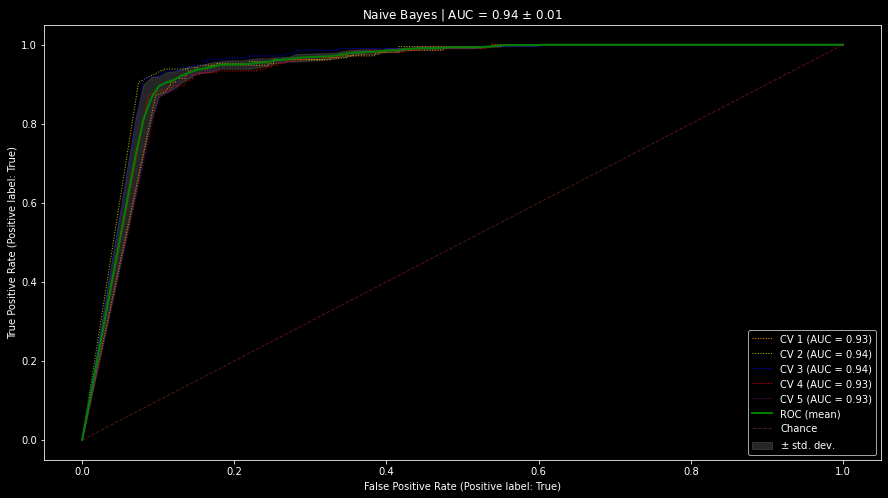

Naive Bayes: avg accuracy: 0.80, avg precision: 0.67, avg recall: 0.93


In [10]:

cv_and_roc(classifier=naive_bayes.GaussianNB(), title='Naive Bayes', X=X, y=y, k=k, colors=colors)

### Decision Tree

Árvores de decisão são estratégias de classificação que se baseiam na divisão lógica de dados com base em critérios binários. Cada critério corresponde a um nó numa estrutura de árvore. Cada nó divide o fluxo subsequente em dois ramos.

O fim de cada ramo é chamado de folha onde um veredito é formulado pelo classificador (i.e.: Procedimento se encerra com uma sentença do tipo 'SE... Senão...' atribuindo o elemento avaliado a uma ou outra classe).

A escolha dos critérios é feita com base na capacidade de separação que cada um pode agregar. O objetivo é que cada "pergunta" (nó) seja muito eficiente em distinguir bem os elementos que restam no respectivo estágio da classificação.

A parametrização de um algoritmo construtor de árvores de decisão inclui delimitar o comprimento máximo da árvore. Quanto maior o comprimento mais específica será a classificação. Entretanto esse grau de especificidade em relação aos dados de treinamento pode ser prejudicial para o alcance da generalização. Logo, uma classificação menos restritiva dos dados de treino pode produzir um  classificador melhor para os dados reais. 

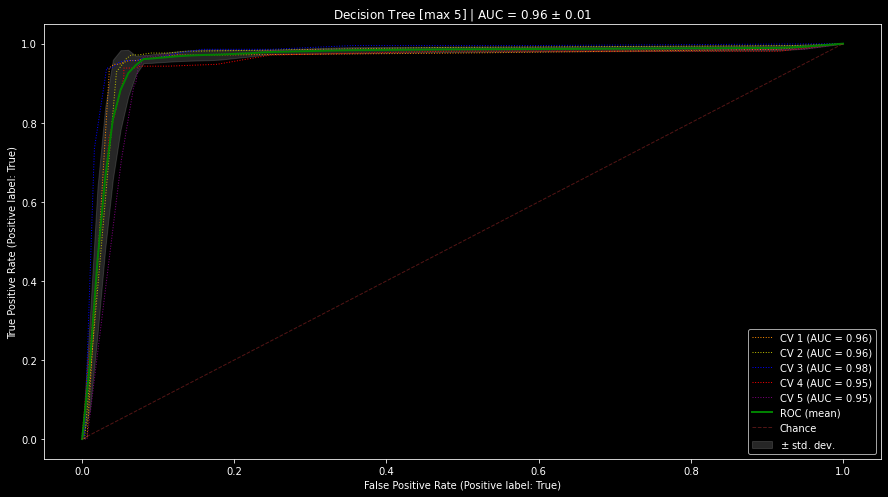

Decision Tree [max 5]: avg accuracy: 0.95, avg precision: 0.92, avg recall: 0.84


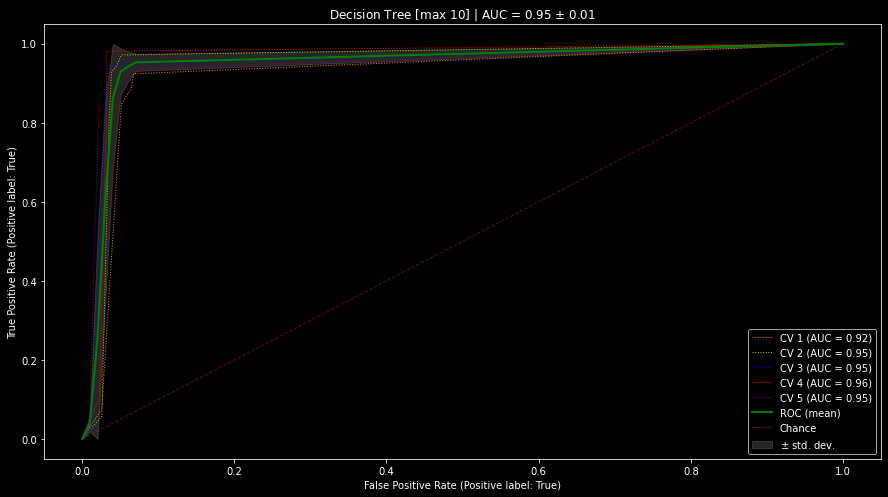

Decision Tree [max 10]: avg accuracy: 0.95, avg precision: 0.93, avg recall: 0.67


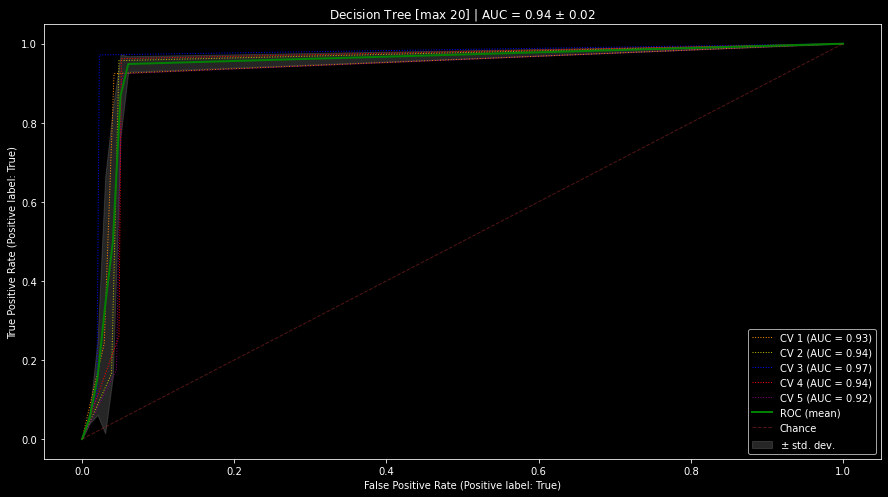

Decision Tree [max 20]: avg accuracy: 0.95, avg precision: 0.94, avg recall: 0.61


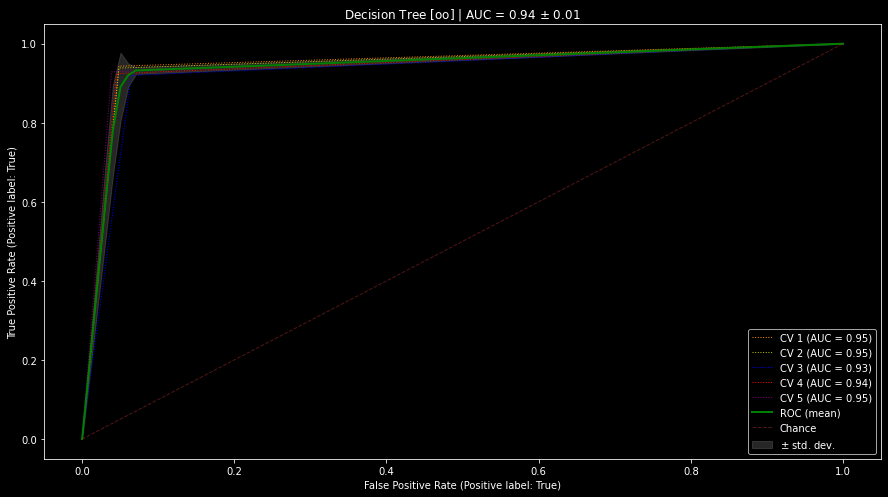

Decision Tree [oo]: avg accuracy: 0.94, avg precision: 0.93, avg recall: 0.64


In [14]:
for max_depth in [5, 10, 20, None]:

    # CV evaluate
    title = 'Decision Tree ' + (r"[max %d]" % (max_depth) if max_depth else '[oo]')
    classifier = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
    cv_and_roc(classifier=classifier, title=title, X=X, y=y, k=k, colors=colors)
    
    # Build tree image
    dot_data = tree.export_graphviz(
        classifier, feature_names=features, class_names=[label_pos, label_neg],
        out_file=None, filled=True, rounded=True,
    )
    graph = graphviz.Source(source=dot_data, format='png', directory='file')

    # Save tree image
    depth_idx_str = ('0' + str(max_depth))[-2:]
    tree_img_name = 'dt-' + (depth_idx_str if max_depth else 'oo')
    graph.render(tree_img_name)

### SVM

Máquinas de vetores de suporte são classificadores que adotam a premissa de que num espaço que contenha amostras de classes diversas, infinitas fronteiras podem ser adotadas como limite de separação. Mas a melhor opção dentre essas todas é aquela cujo a margem entre elementos nas extremidades seja máxima. Ou seja, a fronteira que conseguir se posicionar mais perfeitamente ao centro da distância entre elementos nos limites de cada classe será considerada a melhor.

Nessa abordagem leva-se em conta somente as amostras mais próximas do limite da distribuição de cada dado (os chamados vetores de suporte).

Dois ajustes são fundamentais para este tipo de modelo: O kernel de separação e o fator de regularização.

O Kernel de separação é o tipo de função utilizado para transformar os dados a fim de possibilitar sua separação. Para problemas onde as amostras não se distribuem no espaço de entrada de forma que seja possível traçar um separador trivial (a maioria dos casos) uma transformação algébrica é necessária. A transformação projeta os dados do espaço de entrada num outro espaço onde os pontos projetados possam ser devidamente separados. Cada tipo de kernel possibilita projeções diferentes as quais podem ser mais ou menos adequadas para cada problema.

O fator de regularização é um valor numérico que determina o quão rígido deve ser a separação dos dados i.e.: Qual o nível de tolerância a erros de classificação durante a fase de treinamento. Classificadores muito restritivos tendem a produzir margens de separação muito estreitas o que rende modelos propensos a overfitting.

In [6]:
cValues = [.1, 1, 10, 100]
gammaValues = [.5, 1, 5] # ['scale', 'auto']

#### Linear Kernel

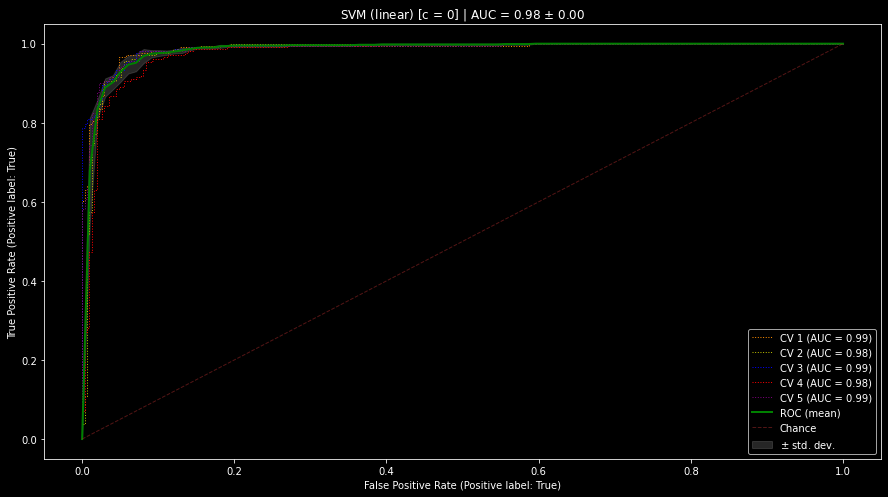

SVM (linear) [c = 0]: avg accuracy: 0.94, avg precision: 0.90, avg recall: 0.81


/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


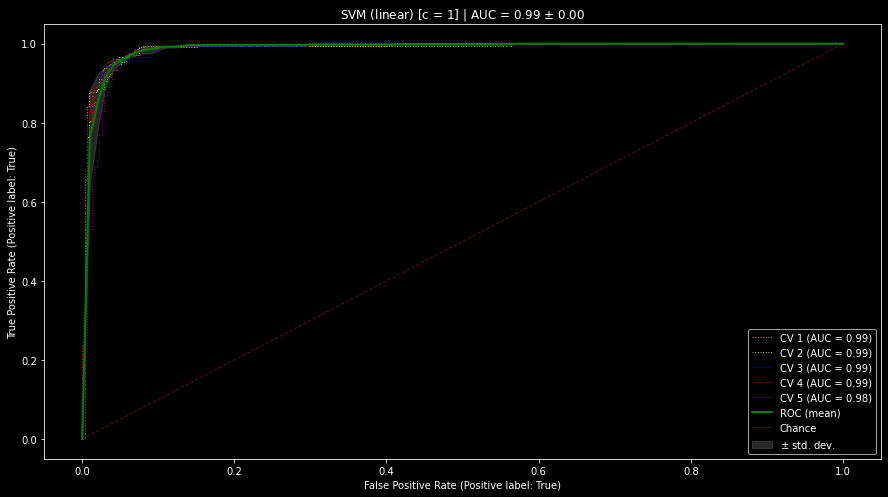

SVM (linear) [c = 1]: avg accuracy: 0.95, avg precision: 0.92, avg recall: 0.83


/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


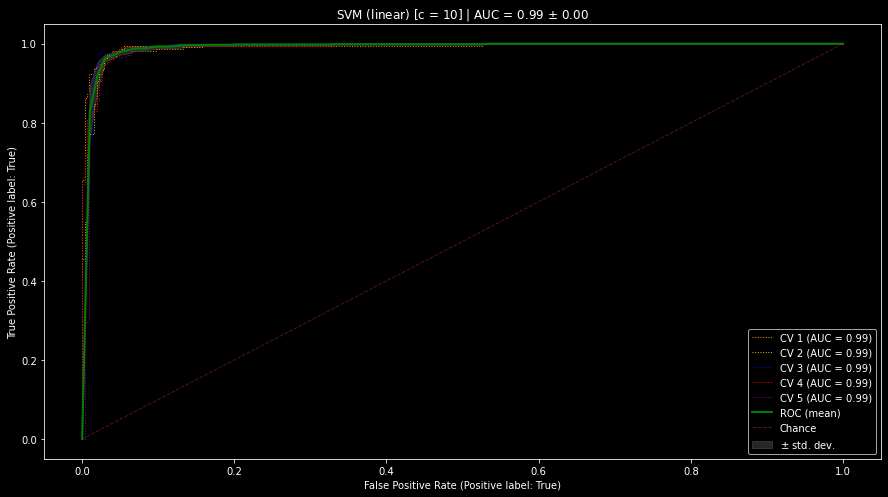

SVM (linear) [c = 10]: avg accuracy: 0.97, avg precision: 0.95, avg recall: 0.82


/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


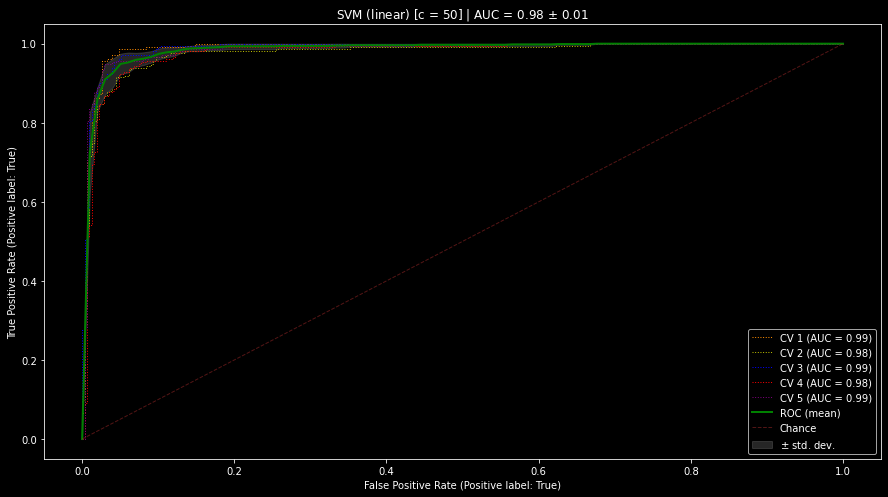

SVM (linear) [c = 50]: avg accuracy: 0.95, avg precision: 0.94, avg recall: 0.82


/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


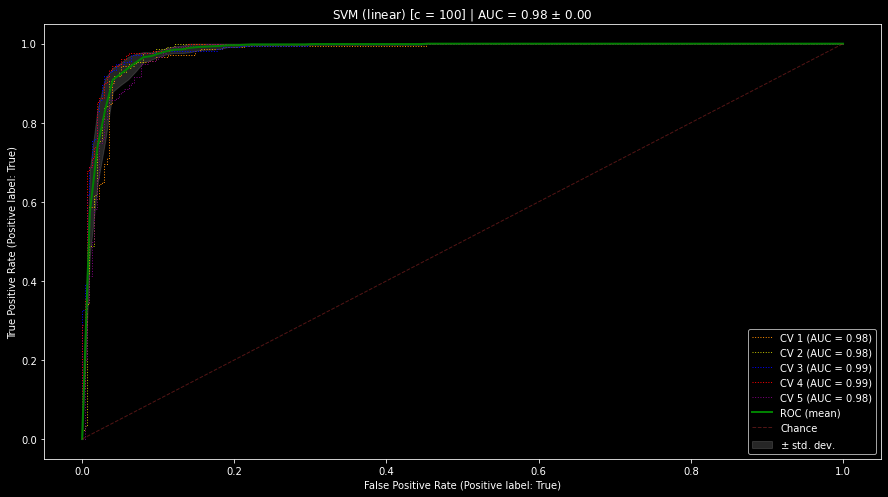

SVM (linear) [c = 100]: avg accuracy: 0.94, avg precision: 0.92, avg recall: 0.78


In [15]:
for c in cValues:
    title = r"SVM (linear) [c = %d]" % (c)
    classifier = svm.LinearSVC(C=c)
    cv_and_roc(classifier=classifier, title=title, X=X, y=y, k=k, colors=colors)

#### Sigmoid Kernel

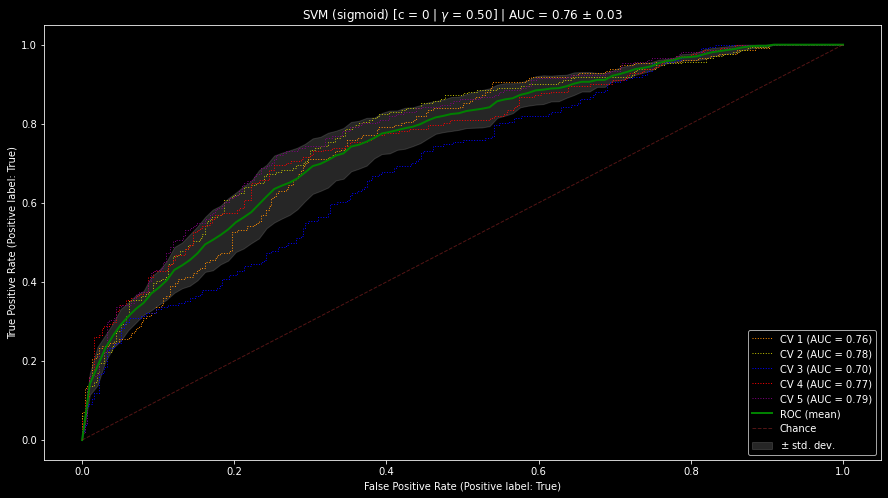

SVM (sigmoid) [c = 0 | $\gamma$ = 0.50]: avg accuracy: 0.70, avg precision: 0.63, avg recall: 0.62


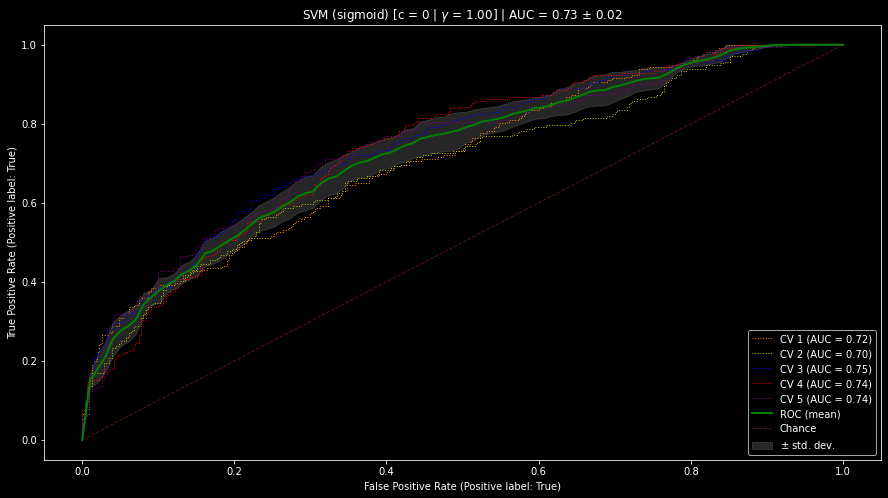

SVM (sigmoid) [c = 0 | $\gamma$ = 1.00]: avg accuracy: 0.68, avg precision: 0.60, avg recall: 0.62


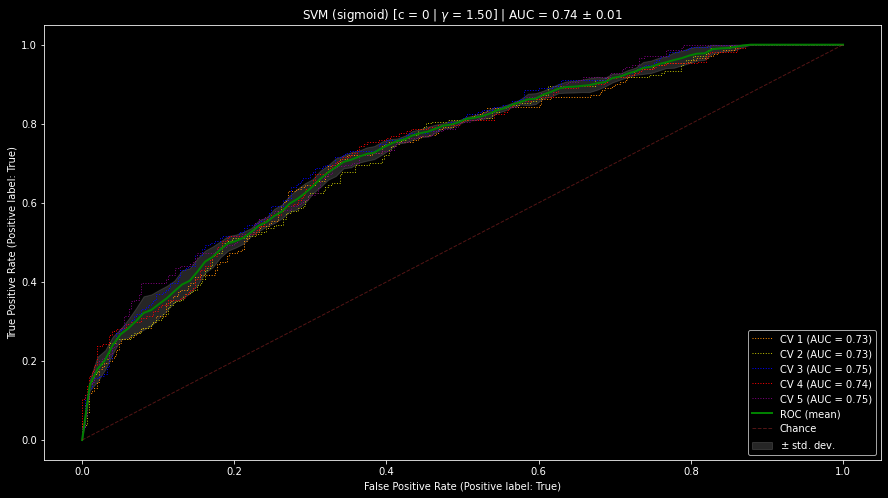

SVM (sigmoid) [c = 0 | $\gamma$ = 1.50]: avg accuracy: 0.67, avg precision: 0.60, avg recall: 0.60


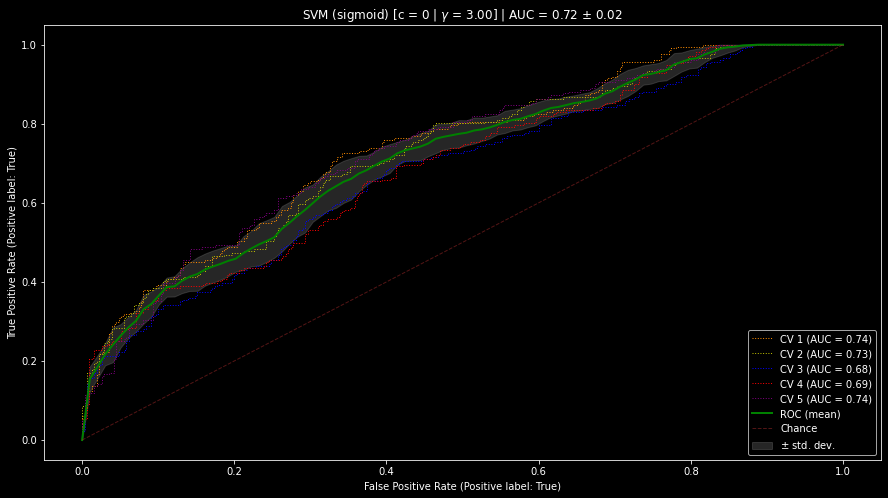

SVM (sigmoid) [c = 0 | $\gamma$ = 3.00]: avg accuracy: 0.66, avg precision: 0.58, avg recall: 0.61


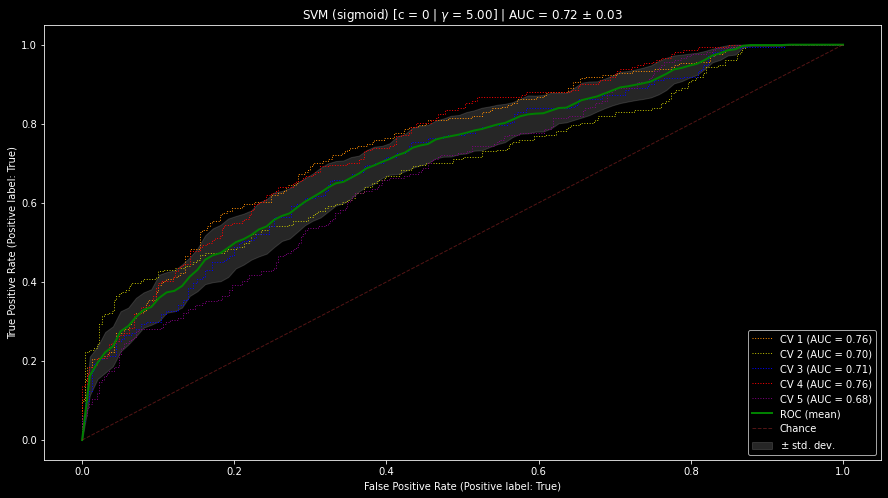

SVM (sigmoid) [c = 0 | $\gamma$ = 5.00]: avg accuracy: 0.67, avg precision: 0.60, avg recall: 0.61


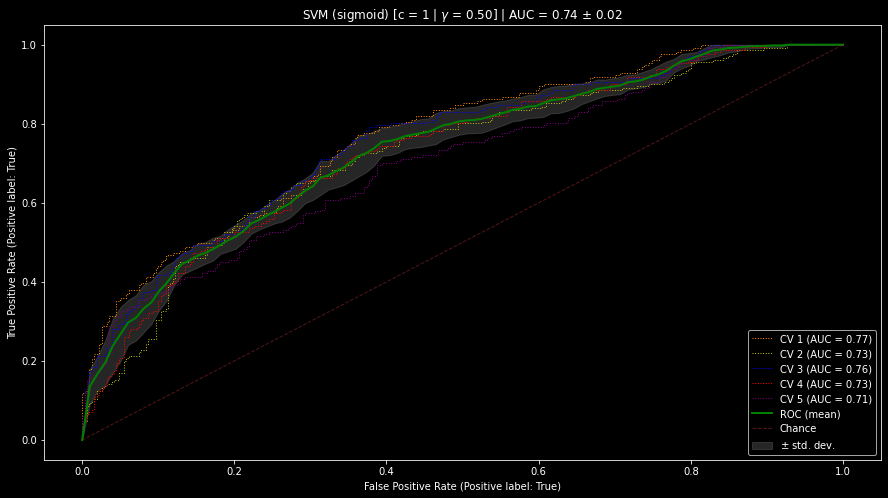

SVM (sigmoid) [c = 1 | $\gamma$ = 0.50]: avg accuracy: 0.68, avg precision: 0.60, avg recall: 0.61


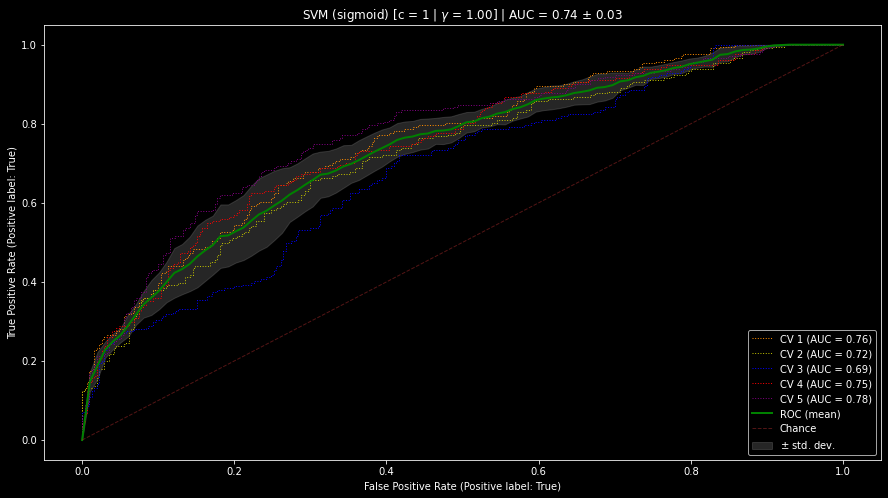

SVM (sigmoid) [c = 1 | $\gamma$ = 1.00]: avg accuracy: 0.69, avg precision: 0.61, avg recall: 0.62


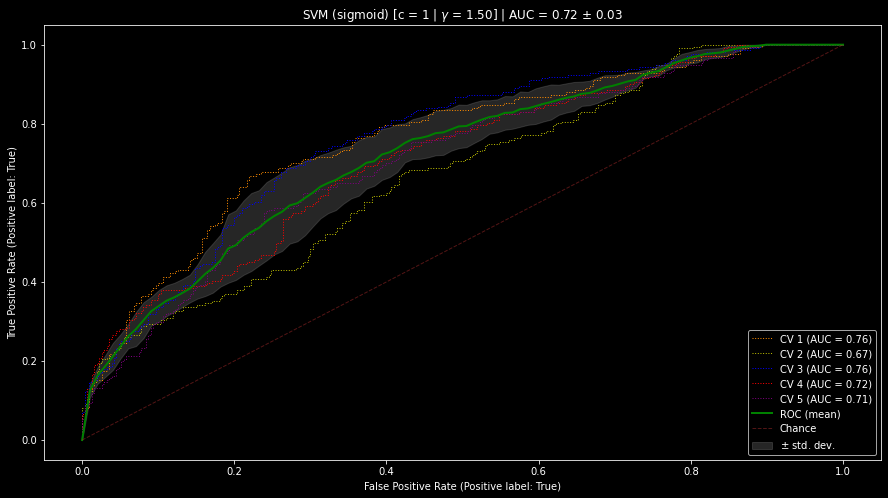

SVM (sigmoid) [c = 1 | $\gamma$ = 1.50]: avg accuracy: 0.67, avg precision: 0.59, avg recall: 0.60


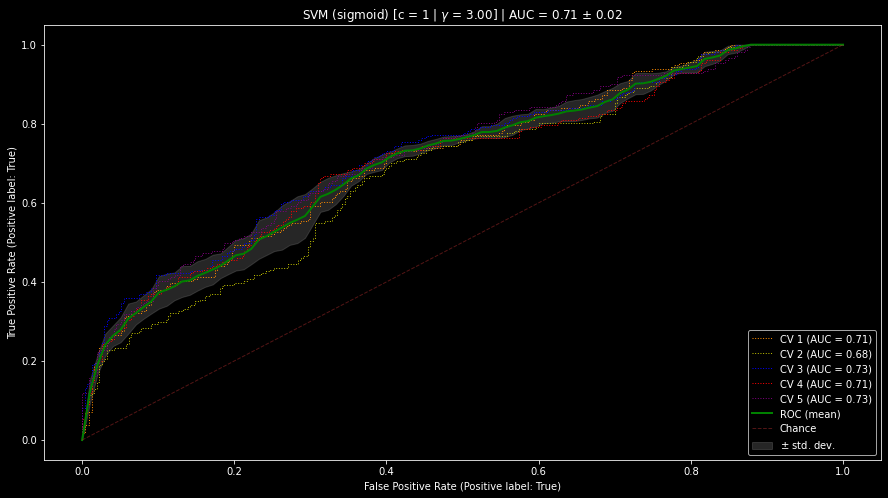

SVM (sigmoid) [c = 1 | $\gamma$ = 3.00]: avg accuracy: 0.66, avg precision: 0.58, avg recall: 0.60


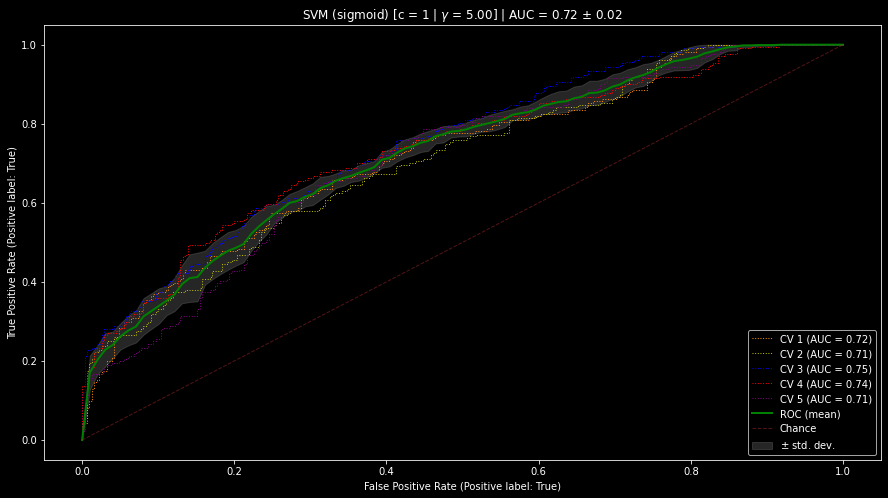

SVM (sigmoid) [c = 1 | $\gamma$ = 5.00]: avg accuracy: 0.67, avg precision: 0.60, avg recall: 0.61


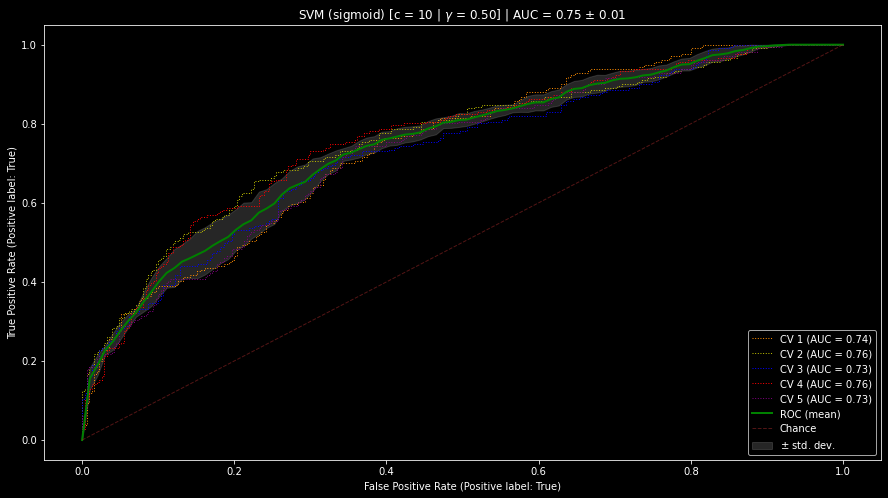

SVM (sigmoid) [c = 10 | $\gamma$ = 0.50]: avg accuracy: 0.69, avg precision: 0.62, avg recall: 0.62


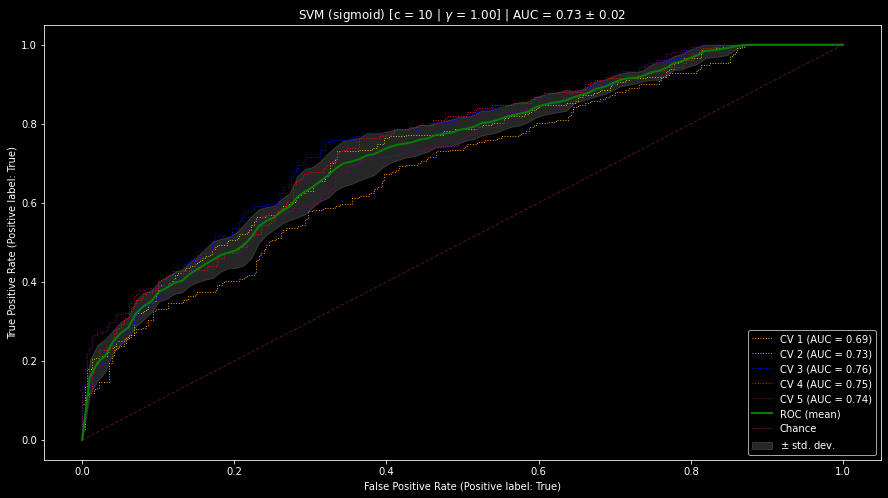

SVM (sigmoid) [c = 10 | $\gamma$ = 1.00]: avg accuracy: 0.67, avg precision: 0.60, avg recall: 0.60


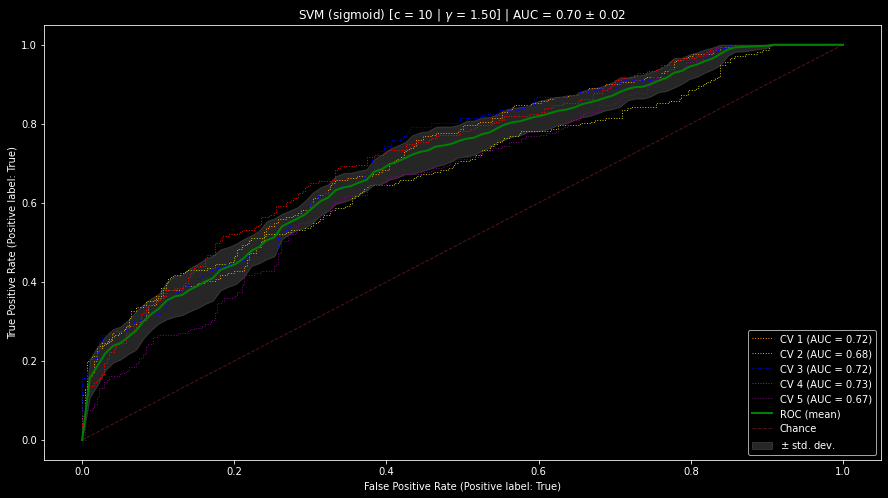

SVM (sigmoid) [c = 10 | $\gamma$ = 1.50]: avg accuracy: 0.66, avg precision: 0.58, avg recall: 0.60


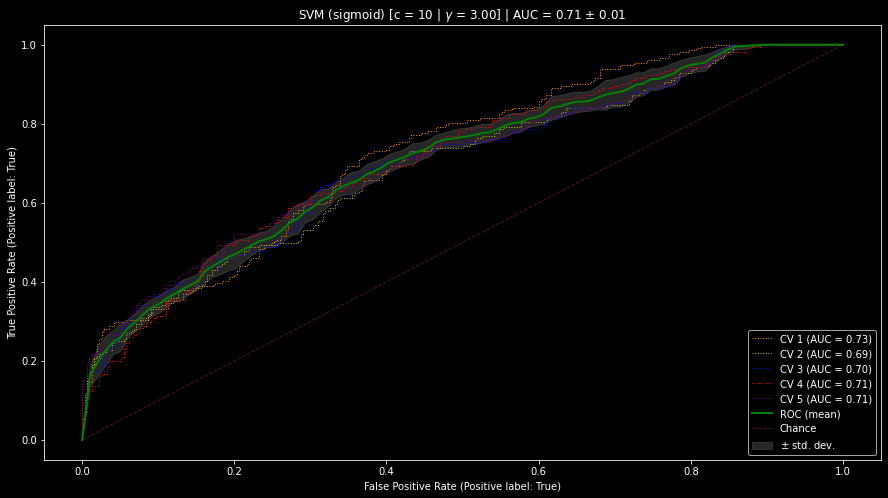

SVM (sigmoid) [c = 10 | $\gamma$ = 3.00]: avg accuracy: 0.65, avg precision: 0.57, avg recall: 0.60


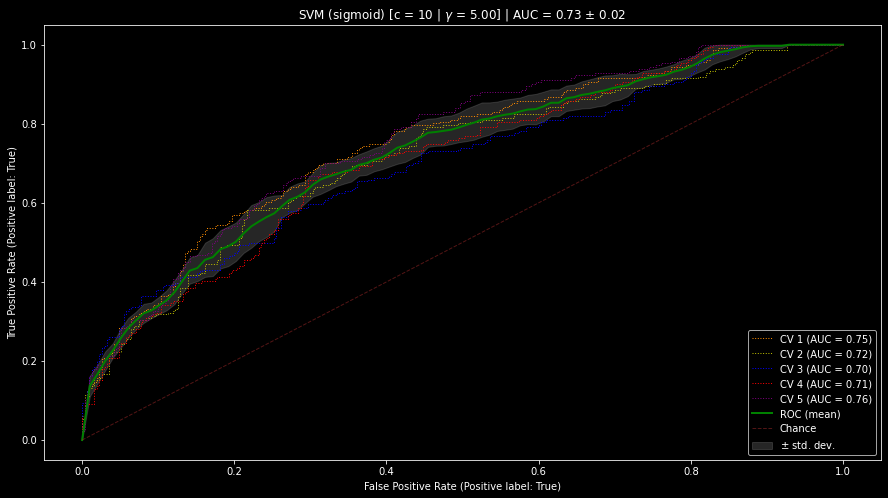

SVM (sigmoid) [c = 10 | $\gamma$ = 5.00]: avg accuracy: 0.68, avg precision: 0.61, avg recall: 0.61


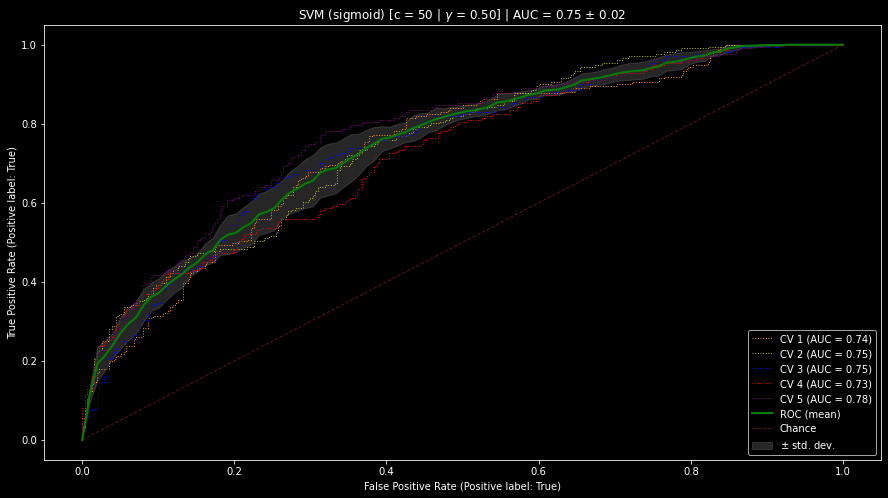

SVM (sigmoid) [c = 50 | $\gamma$ = 0.50]: avg accuracy: 0.68, avg precision: 0.60, avg recall: 0.62


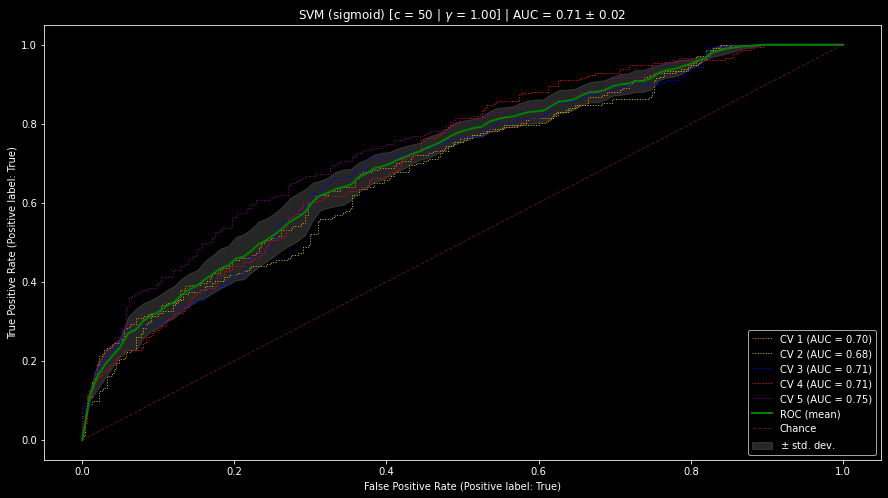

SVM (sigmoid) [c = 50 | $\gamma$ = 1.00]: avg accuracy: 0.66, avg precision: 0.58, avg recall: 0.58


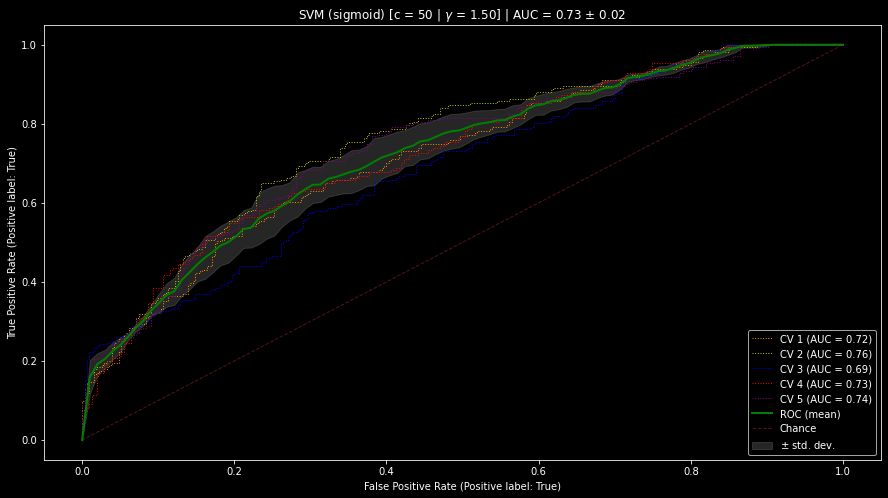

SVM (sigmoid) [c = 50 | $\gamma$ = 1.50]: avg accuracy: 0.68, avg precision: 0.61, avg recall: 0.61


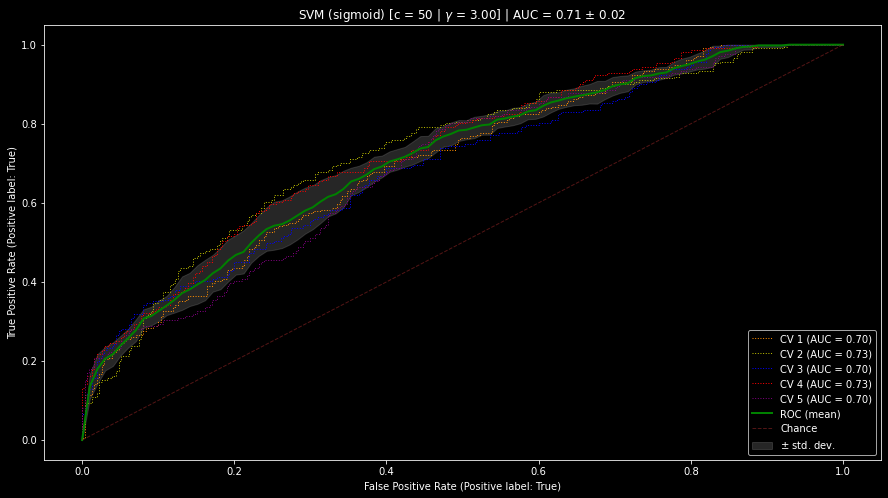

SVM (sigmoid) [c = 50 | $\gamma$ = 3.00]: avg accuracy: 0.66, avg precision: 0.58, avg recall: 0.59


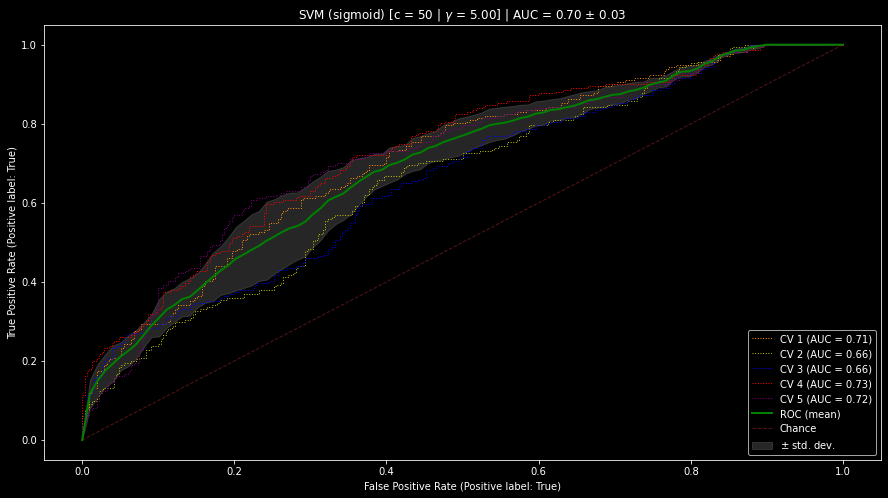

SVM (sigmoid) [c = 50 | $\gamma$ = 5.00]: avg accuracy: 0.66, avg precision: 0.58, avg recall: 0.58


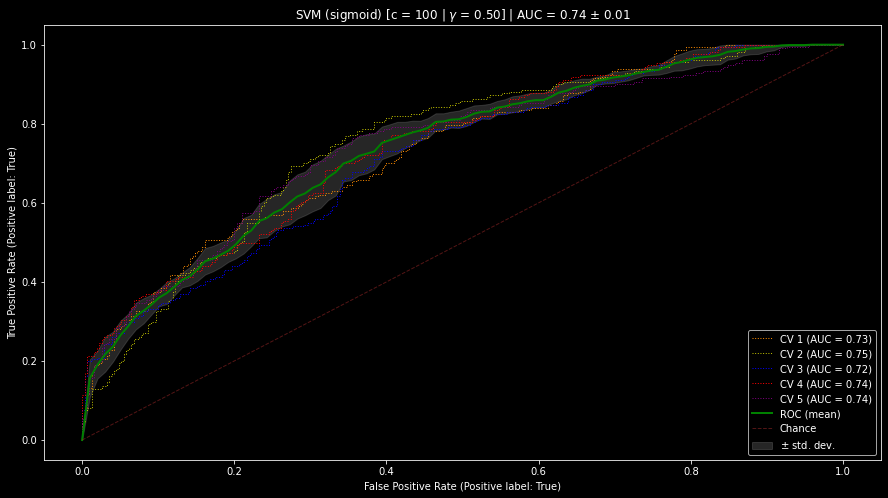

SVM (sigmoid) [c = 100 | $\gamma$ = 0.50]: avg accuracy: 0.67, avg precision: 0.59, avg recall: 0.61


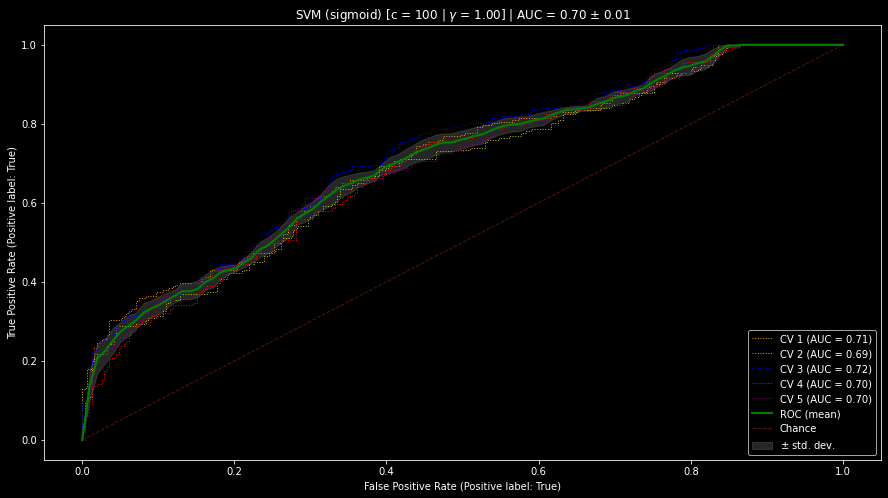

SVM (sigmoid) [c = 100 | $\gamma$ = 1.00]: avg accuracy: 0.65, avg precision: 0.58, avg recall: 0.60


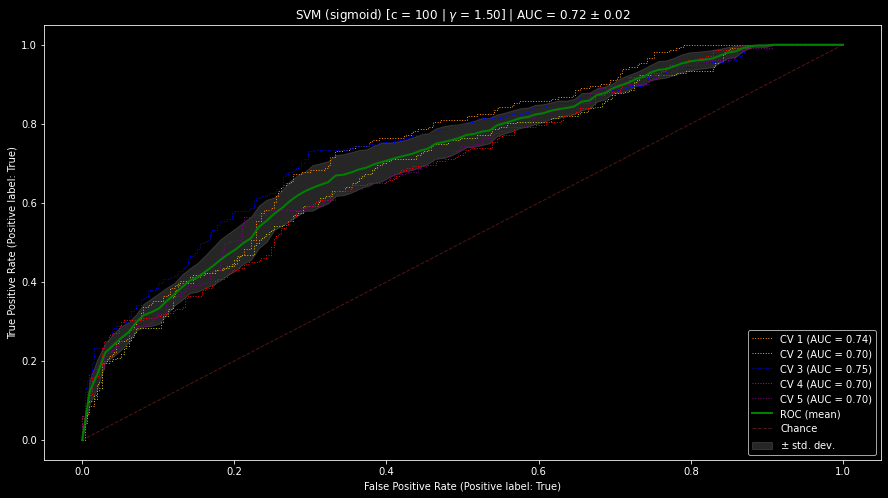

SVM (sigmoid) [c = 100 | $\gamma$ = 1.50]: avg accuracy: 0.67, avg precision: 0.59, avg recall: 0.60


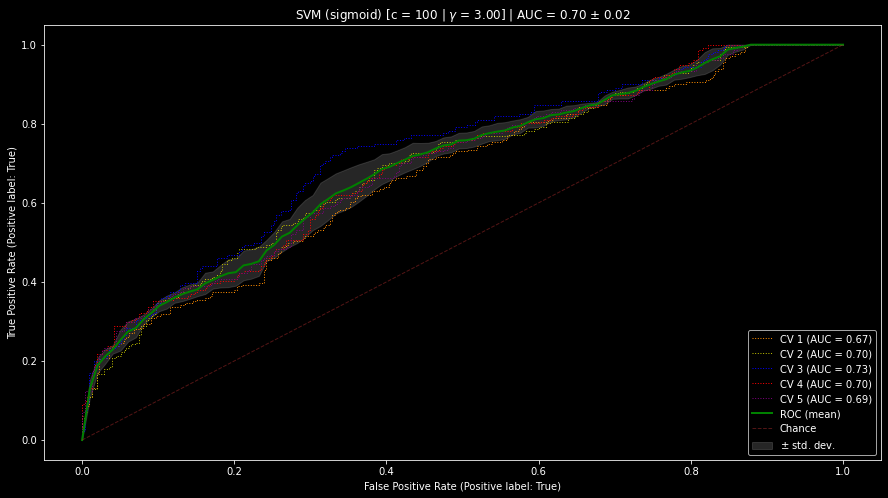

SVM (sigmoid) [c = 100 | $\gamma$ = 3.00]: avg accuracy: 0.65, avg precision: 0.57, avg recall: 0.59


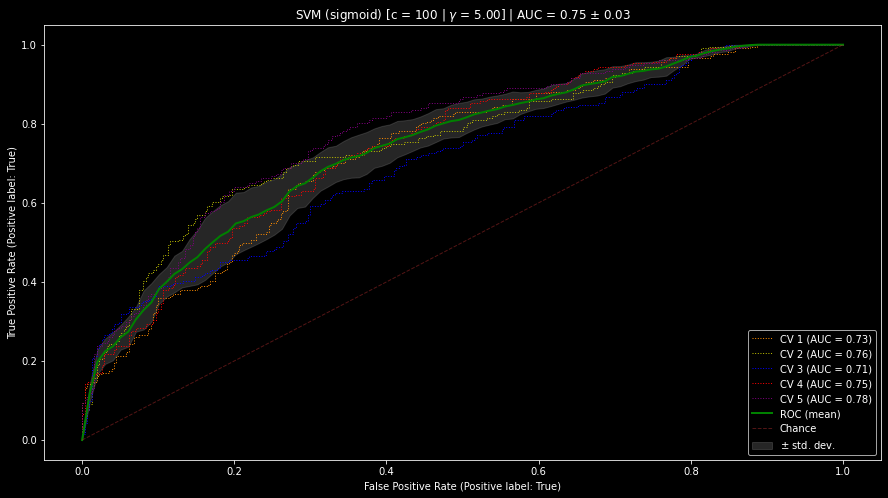

SVM (sigmoid) [c = 100 | $\gamma$ = 5.00]: avg accuracy: 0.69, avg precision: 0.61, avg recall: 0.62


In [16]:
for c in cValues:
    for gamma in gammaValues:
        title = r"SVM (sigmoid) [c = %.2f | $\gamma$ = %.2f]" % (c, gamma)
        classifier = svm.SVC(C=c, kernel='sigmoid', gamma=gamma)
        cv_and_roc(classifier=classifier, title=title, X=X, y=y, k=k, colors=colors)

#### Polynomial kernel

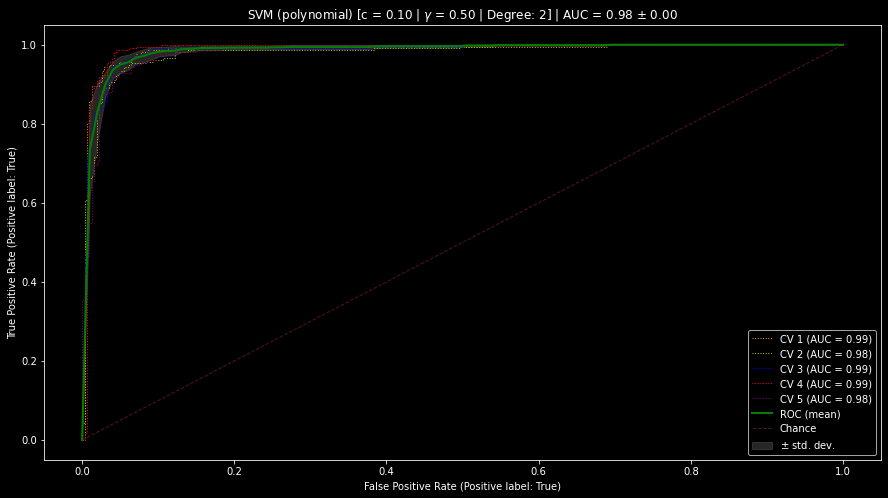

SVM (polynomial) [c = 0.10 | $\gamma$ = 0.50 | Degree: 2]: avg accuracy: 0.95, avg precision: 0.92, avg recall: 0.82


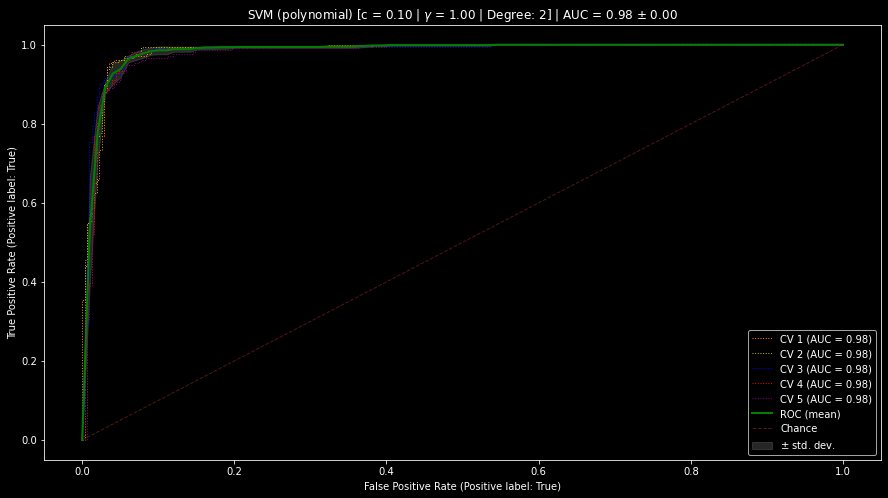

SVM (polynomial) [c = 0.10 | $\gamma$ = 1.00 | Degree: 2]: avg accuracy: 0.95, avg precision: 0.91, avg recall: 0.78


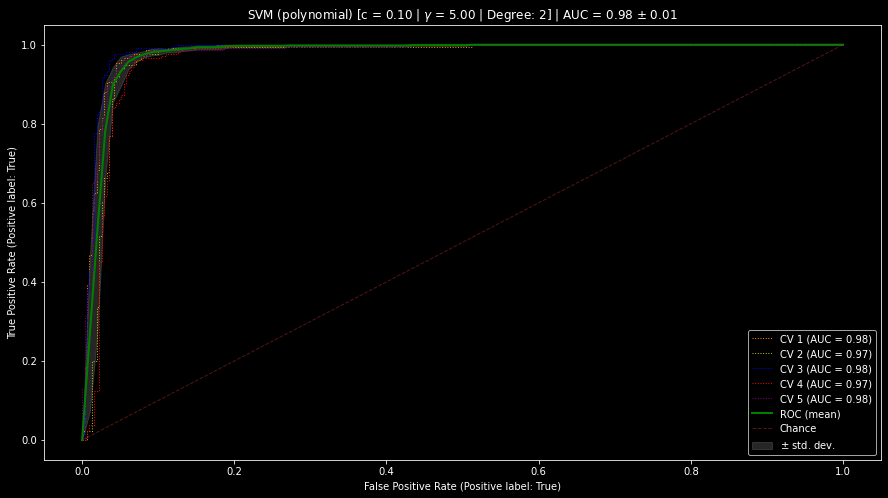

SVM (polynomial) [c = 0.10 | $\gamma$ = 5.00 | Degree: 2]: avg accuracy: 0.95, avg precision: 0.91, avg recall: 0.73


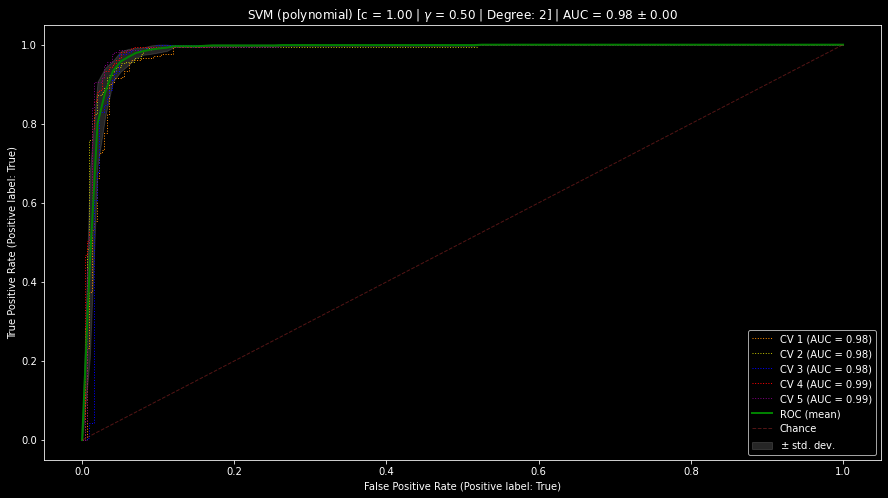

SVM (polynomial) [c = 1.00 | $\gamma$ = 0.50 | Degree: 2]: avg accuracy: 0.95, avg precision: 0.92, avg recall: 0.78


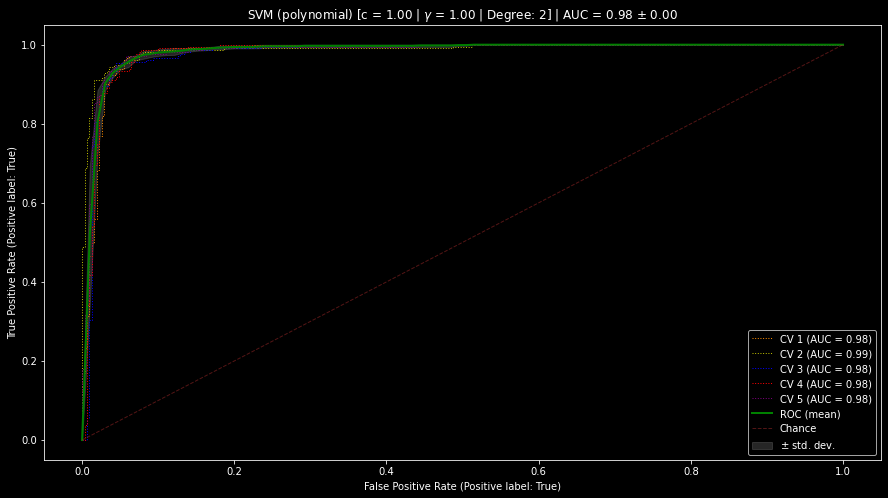

SVM (polynomial) [c = 1.00 | $\gamma$ = 1.00 | Degree: 2]: avg accuracy: 0.95, avg precision: 0.92, avg recall: 0.79


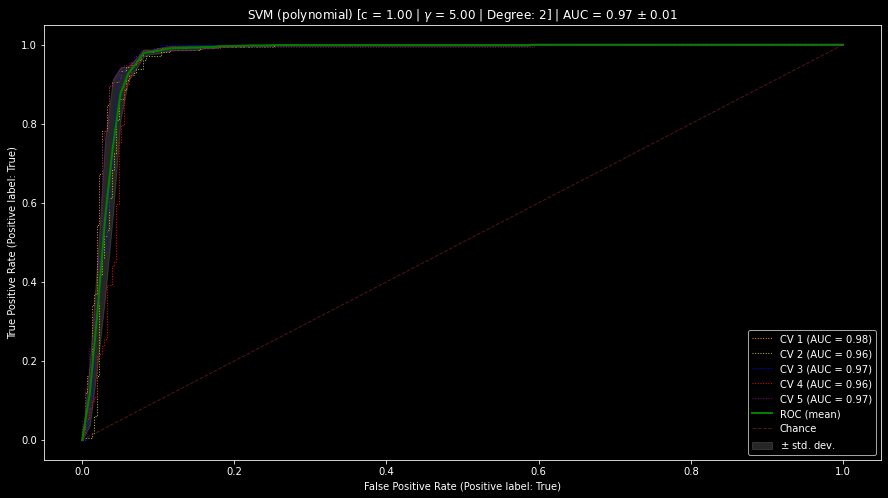

SVM (polynomial) [c = 1.00 | $\gamma$ = 5.00 | Degree: 2]: avg accuracy: 0.94, avg precision: 0.91, avg recall: 0.65


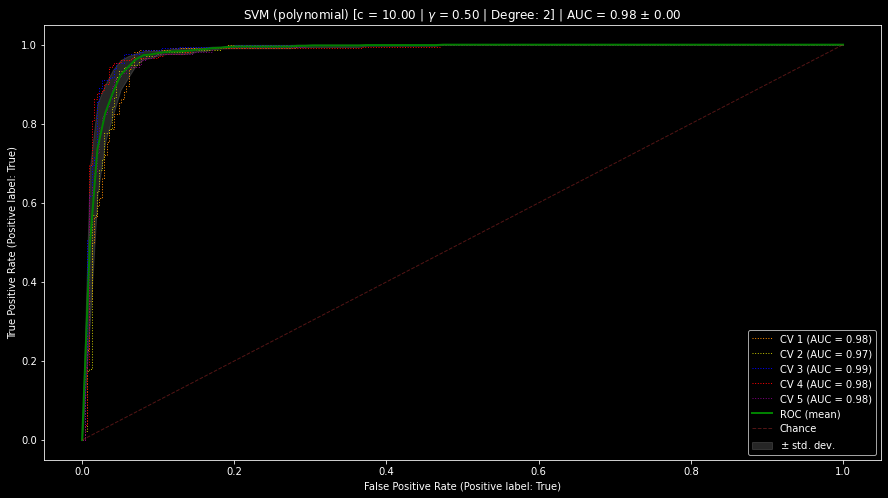

SVM (polynomial) [c = 10.00 | $\gamma$ = 0.50 | Degree: 2]: avg accuracy: 0.94, avg precision: 0.92, avg recall: 0.77


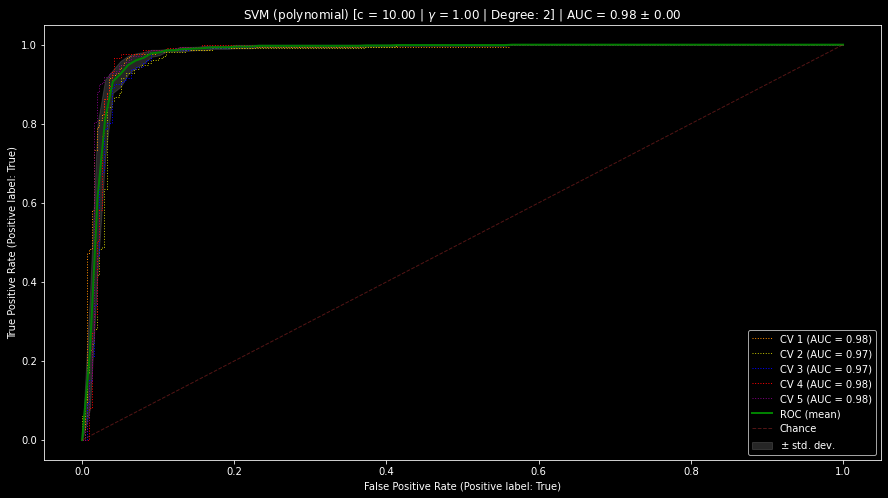

SVM (polynomial) [c = 10.00 | $\gamma$ = 1.00 | Degree: 2]: avg accuracy: 0.94, avg precision: 0.91, avg recall: 0.73


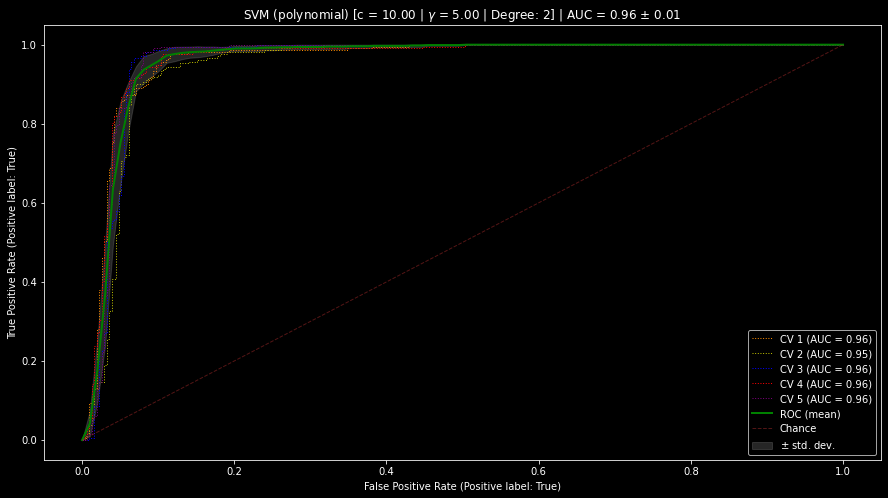

SVM (polynomial) [c = 10.00 | $\gamma$ = 5.00 | Degree: 2]: avg accuracy: 0.92, avg precision: 0.90, avg recall: 0.66


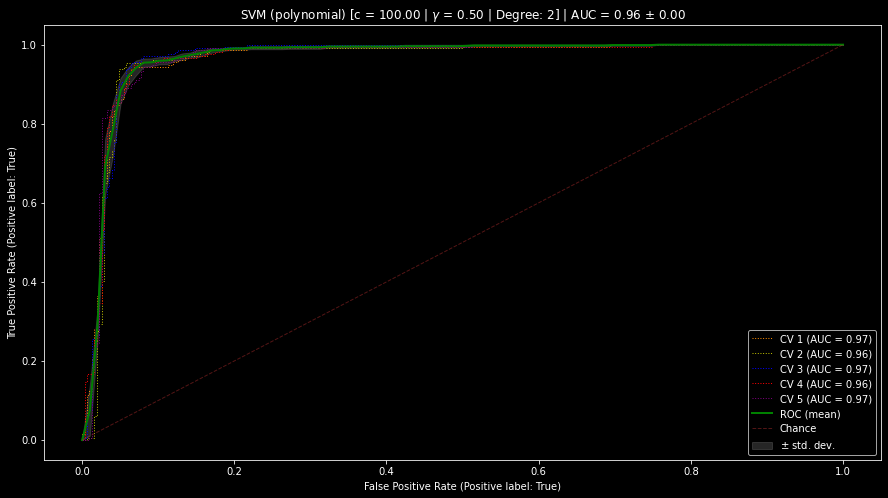

SVM (polynomial) [c = 100.00 | $\gamma$ = 0.50 | Degree: 2]: avg accuracy: 0.93, avg precision: 0.91, avg recall: 0.72


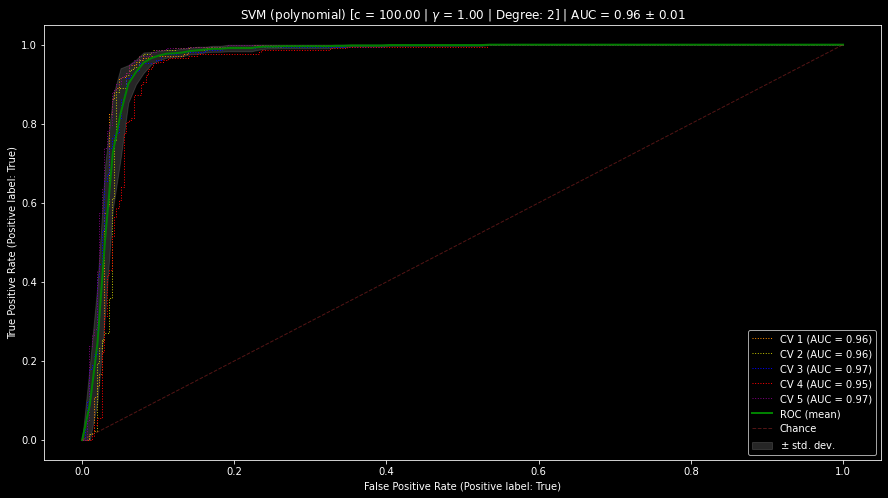

SVM (polynomial) [c = 100.00 | $\gamma$ = 1.00 | Degree: 2]: avg accuracy: 0.93, avg precision: 0.90, avg recall: 0.68


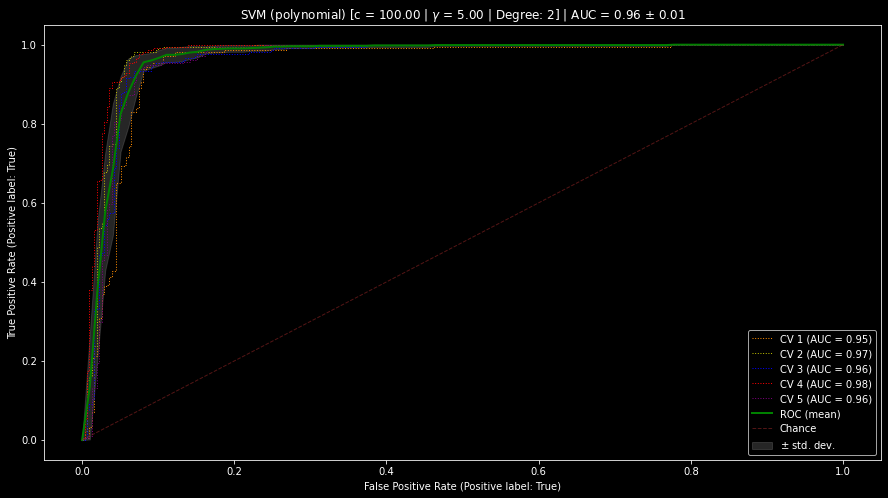

SVM (polynomial) [c = 100.00 | $\gamma$ = 5.00 | Degree: 2]: avg accuracy: 0.93, avg precision: 0.91, avg recall: 0.69


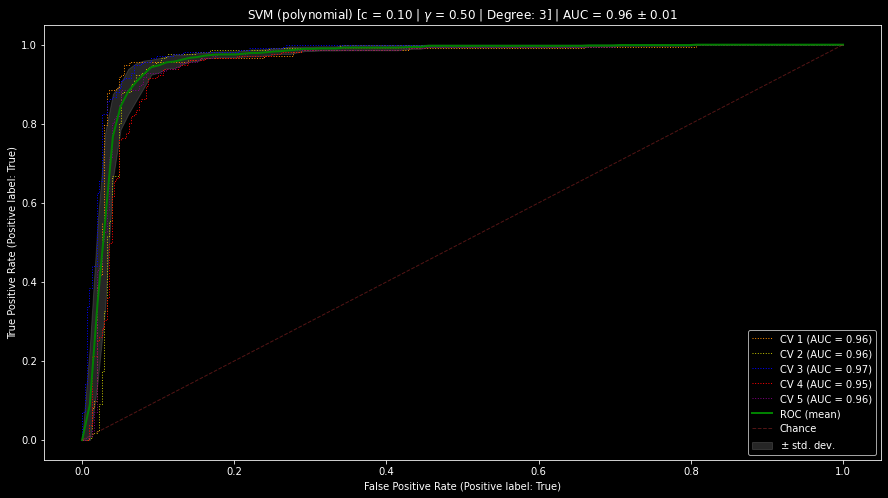

SVM (polynomial) [c = 0.10 | $\gamma$ = 0.50 | Degree: 3]: avg accuracy: 0.92, avg precision: 0.87, avg recall: 0.71


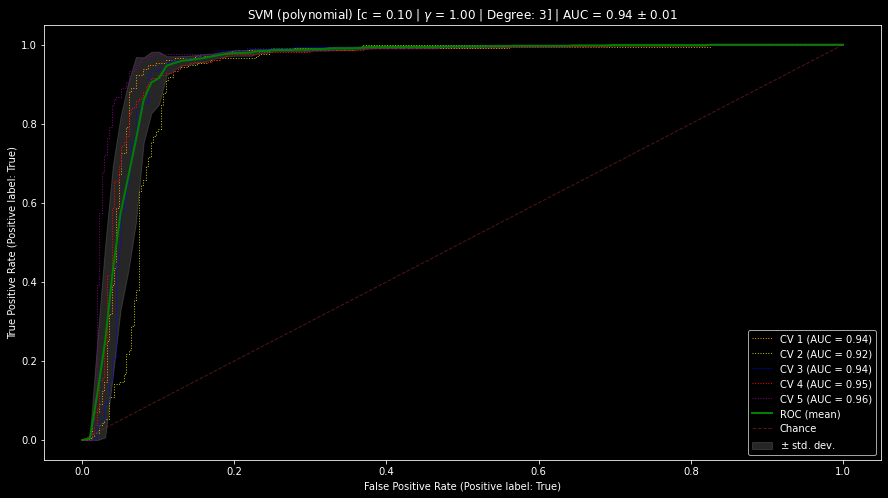

SVM (polynomial) [c = 0.10 | $\gamma$ = 1.00 | Degree: 3]: avg accuracy: 0.92, avg precision: 0.86, avg recall: 0.66


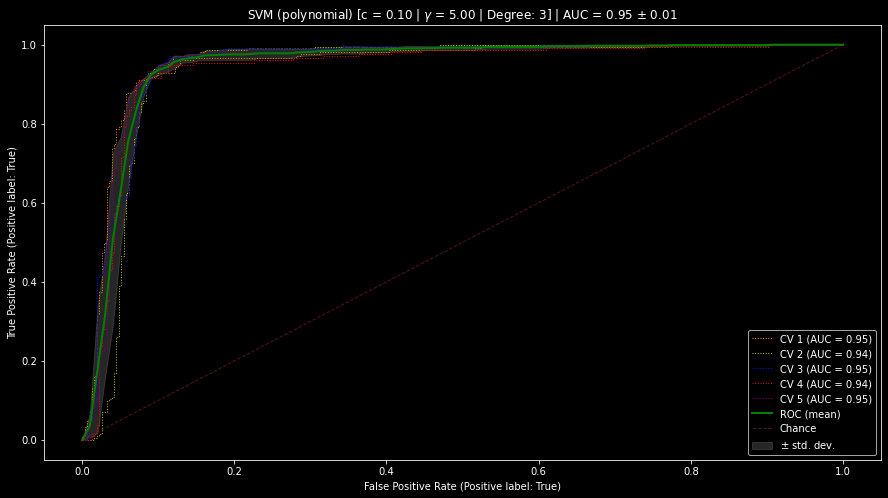

SVM (polynomial) [c = 0.10 | $\gamma$ = 5.00 | Degree: 3]: avg accuracy: 0.91, avg precision: 0.87, avg recall: 0.67


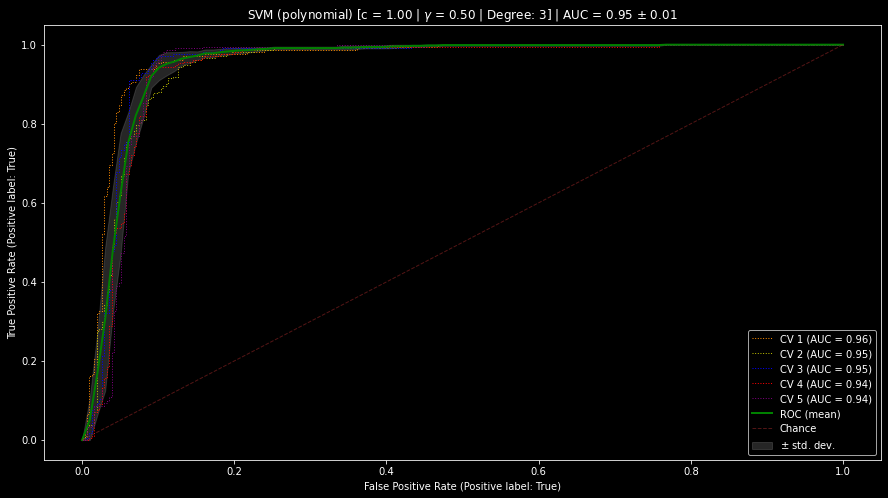

SVM (polynomial) [c = 1.00 | $\gamma$ = 0.50 | Degree: 3]: avg accuracy: 0.92, avg precision: 0.87, avg recall: 0.65


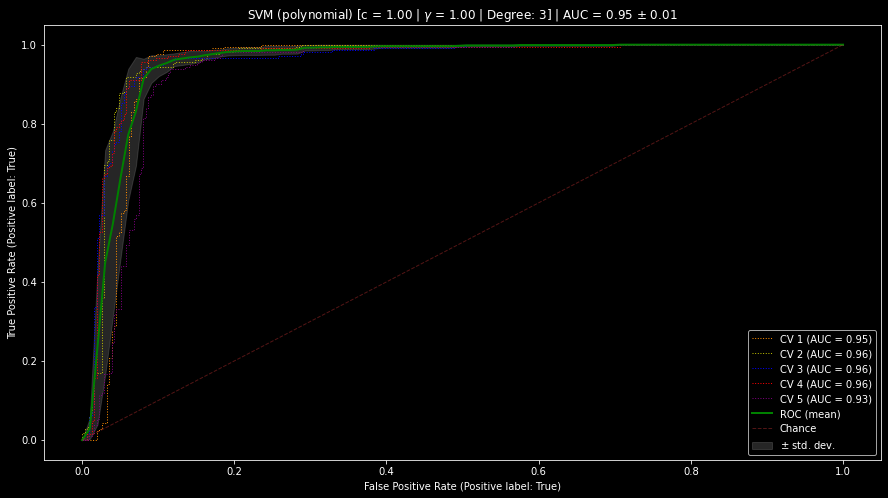

SVM (polynomial) [c = 1.00 | $\gamma$ = 1.00 | Degree: 3]: avg accuracy: 0.92, avg precision: 0.88, avg recall: 0.67


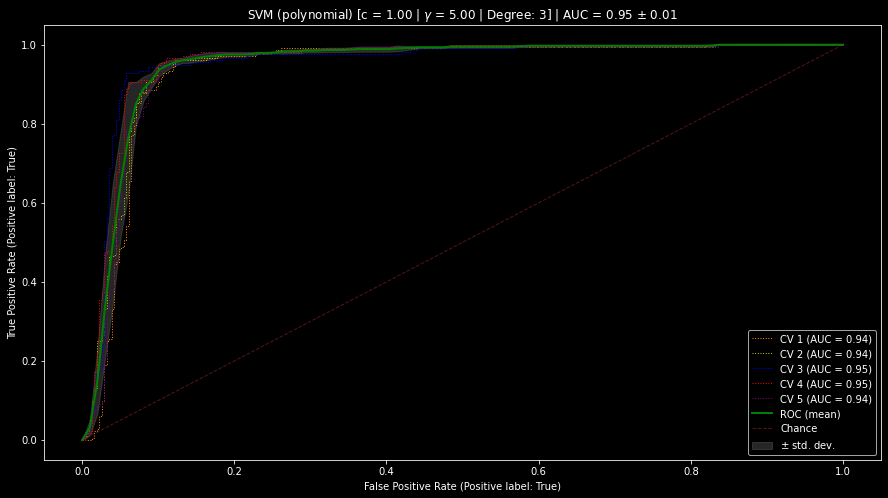

SVM (polynomial) [c = 1.00 | $\gamma$ = 5.00 | Degree: 3]: avg accuracy: 0.91, avg precision: 0.87, avg recall: 0.64


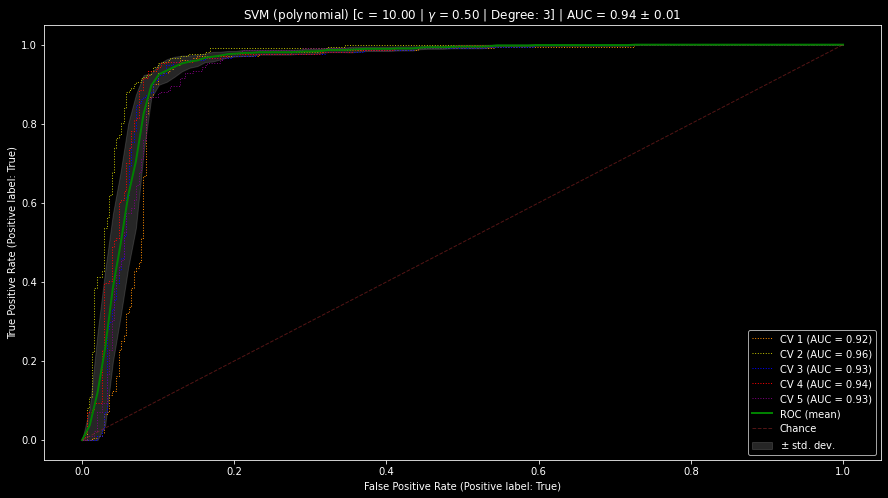

SVM (polynomial) [c = 10.00 | $\gamma$ = 0.50 | Degree: 3]: avg accuracy: 0.91, avg precision: 0.86, avg recall: 0.66


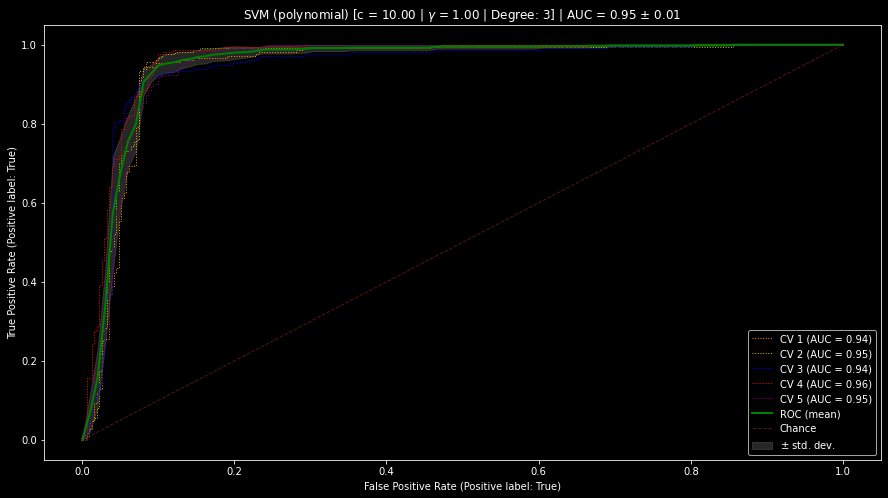

SVM (polynomial) [c = 10.00 | $\gamma$ = 1.00 | Degree: 3]: avg accuracy: 0.92, avg precision: 0.88, avg recall: 0.66


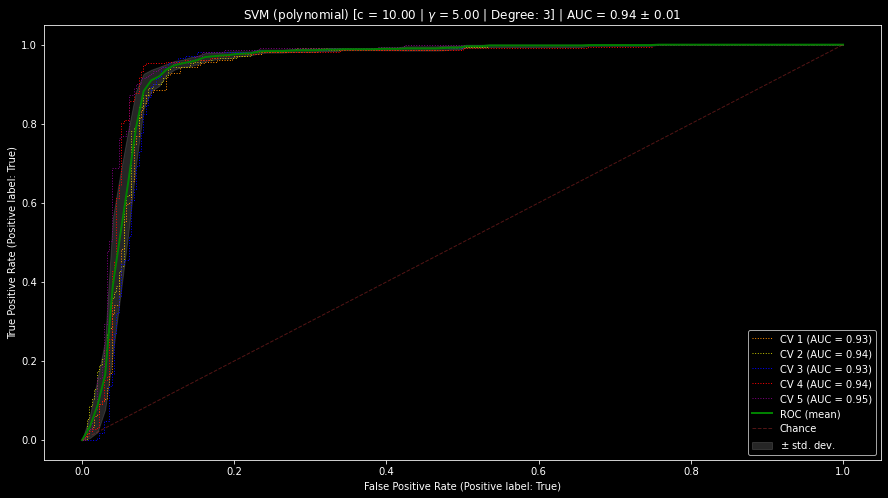

SVM (polynomial) [c = 10.00 | $\gamma$ = 5.00 | Degree: 3]: avg accuracy: 0.91, avg precision: 0.86, avg recall: 0.63


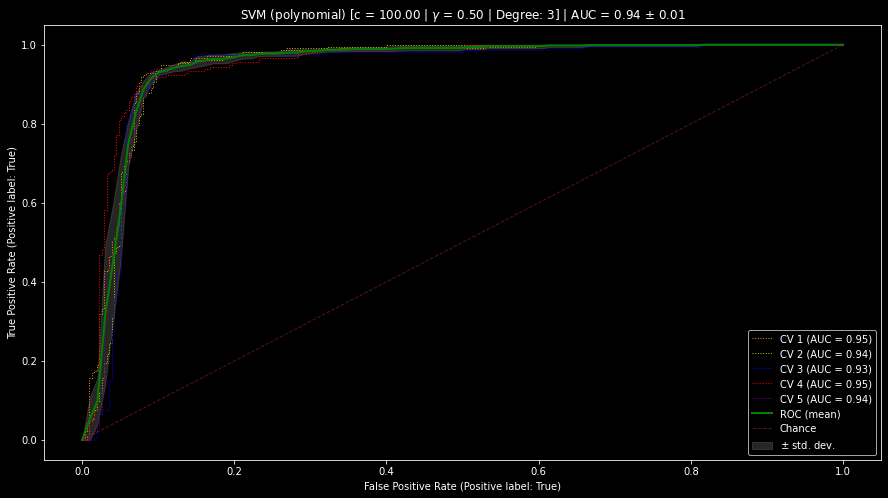

SVM (polynomial) [c = 100.00 | $\gamma$ = 0.50 | Degree: 3]: avg accuracy: 0.91, avg precision: 0.87, avg recall: 0.67


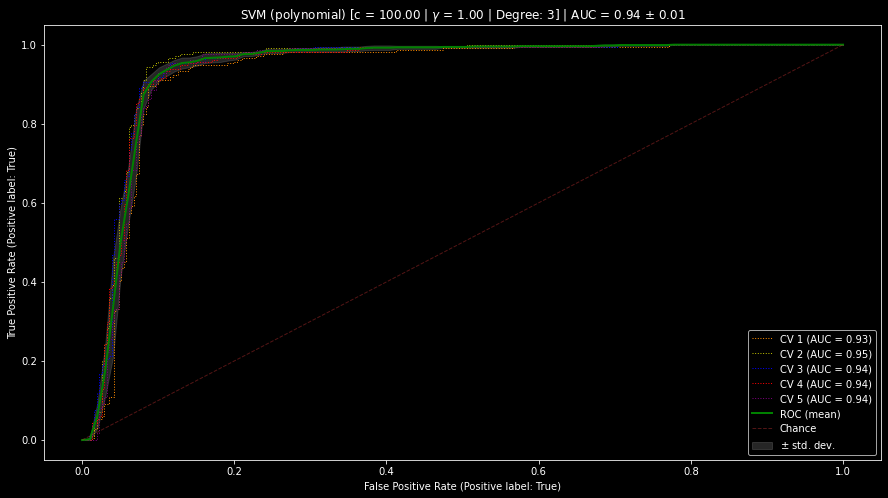

SVM (polynomial) [c = 100.00 | $\gamma$ = 1.00 | Degree: 3]: avg accuracy: 0.91, avg precision: 0.86, avg recall: 0.66


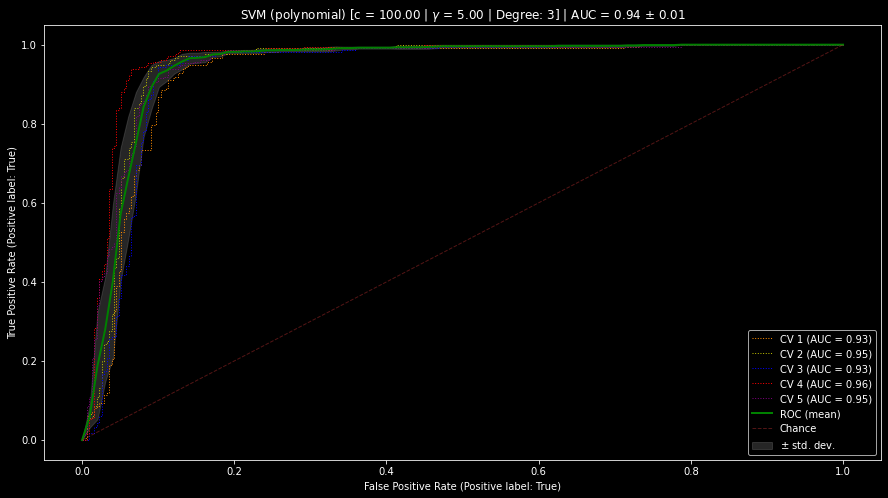

SVM (polynomial) [c = 100.00 | $\gamma$ = 5.00 | Degree: 3]: avg accuracy: 0.91, avg precision: 0.86, avg recall: 0.64


In [19]:
for pDegree in [2, 3]:
    for c in cValues:
        for gamma in gammaValues:
            title = r"SVM (polynomial) [c = %.2f | $\gamma$ = %.2f | Degree: %d]" % (c, gamma, pDegree)
            classifier = svm.SVC(C=c, kernel='poly', gamma=gamma, degree=pDegree)
            cv_and_roc(classifier=classifier, title=title, X=X, y=y, k=k, colors=colors)

#### RBF Kernel

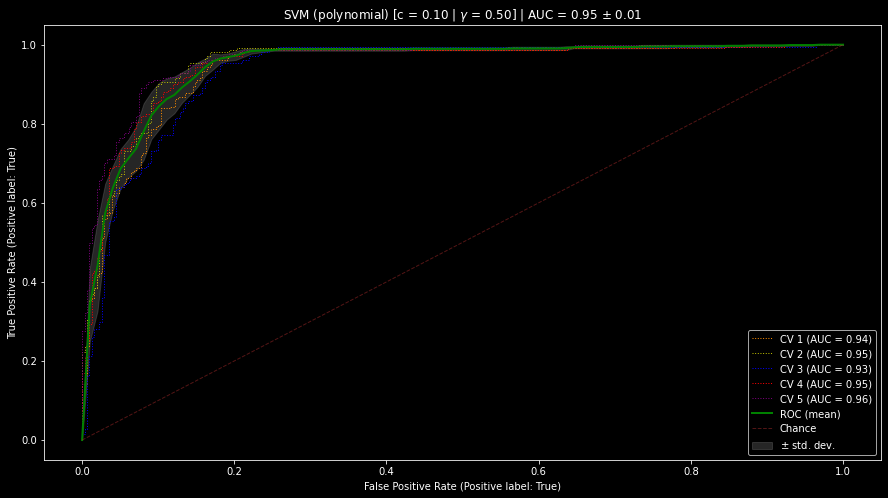

SVM (polynomial) [c = 0.10 | $\gamma$ = 0.50]: avg accuracy: 0.78, avg precision: 0.93, avg recall: 0.73


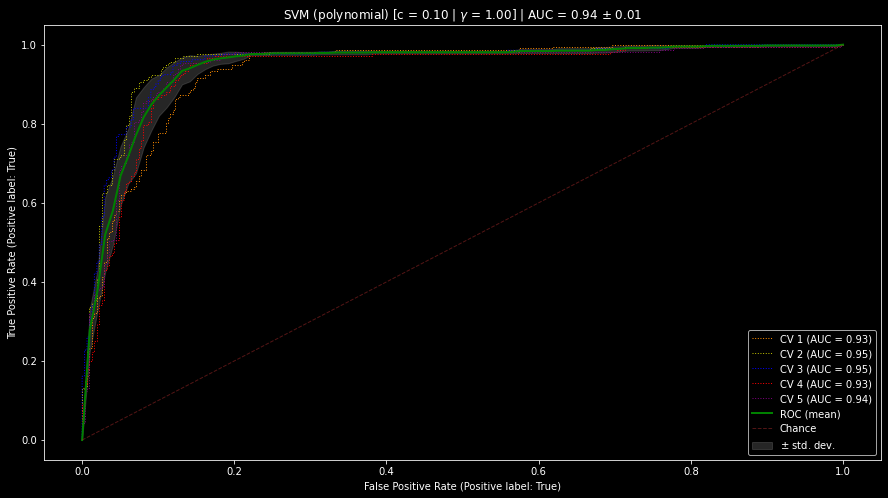

SVM (polynomial) [c = 0.10 | $\gamma$ = 1.00]: avg accuracy: 0.62, avg precision: 0.99, avg recall: 0.71


/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedM

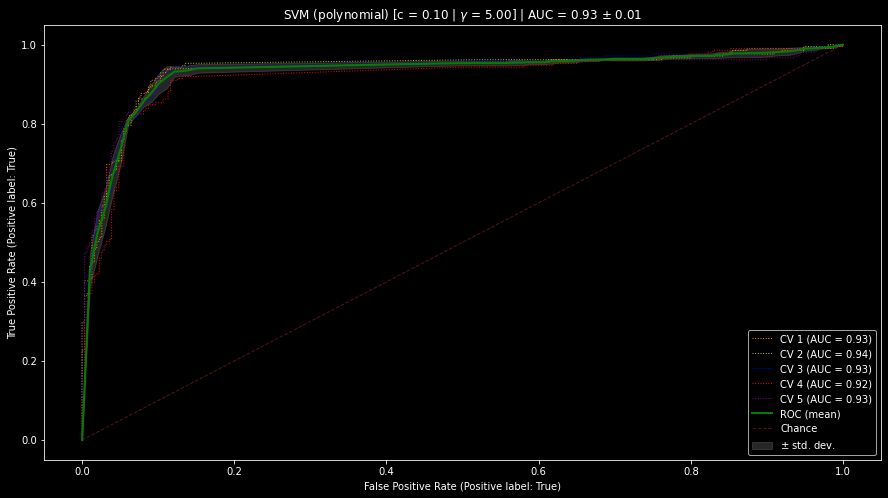

SVM (polynomial) [c = 0.10 | $\gamma$ = 5.00]: avg accuracy: 0.60, avg precision: 0.00, avg recall: 0.77


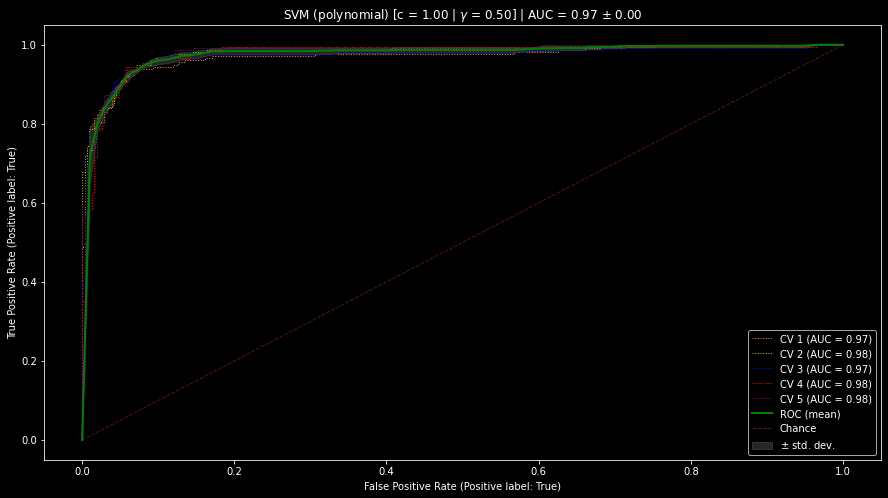

SVM (polynomial) [c = 1.00 | $\gamma$ = 0.50]: avg accuracy: 0.92, avg precision: 0.95, avg recall: 0.85


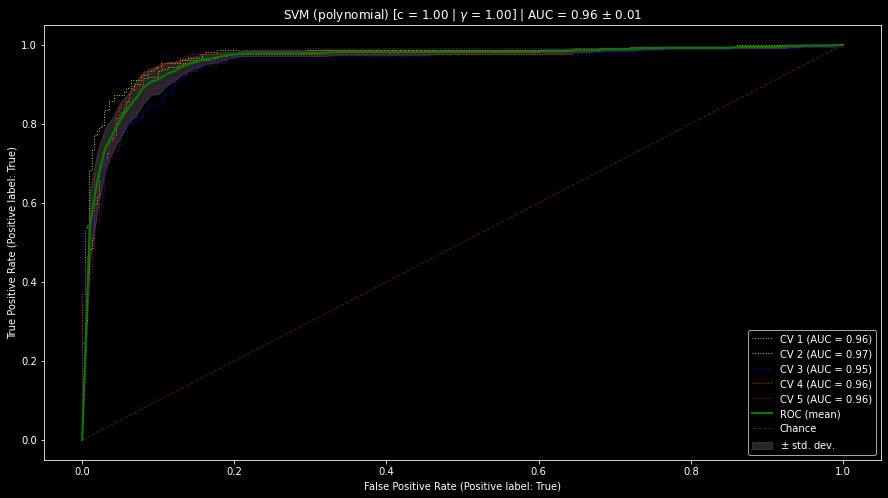

SVM (polynomial) [c = 1.00 | $\gamma$ = 1.00]: avg accuracy: 0.86, avg precision: 0.96, avg recall: 0.80


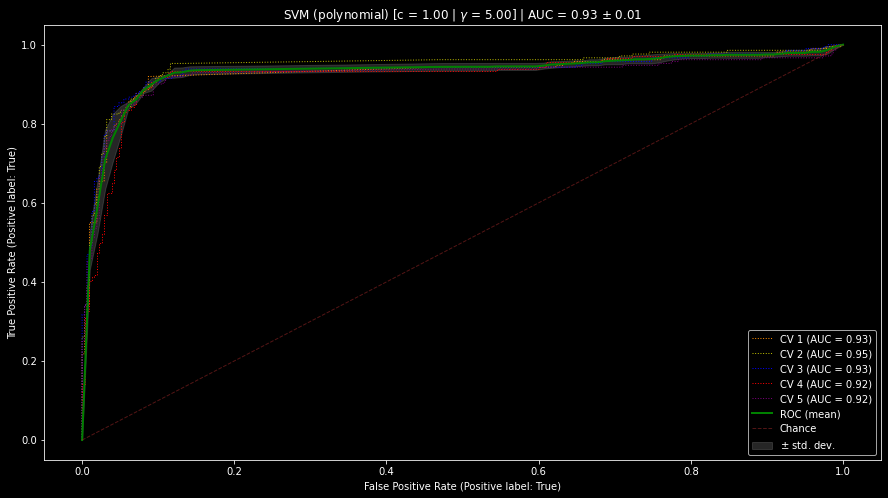

SVM (polynomial) [c = 1.00 | $\gamma$ = 5.00]: avg accuracy: 0.62, avg precision: 1.00, avg recall: 0.79


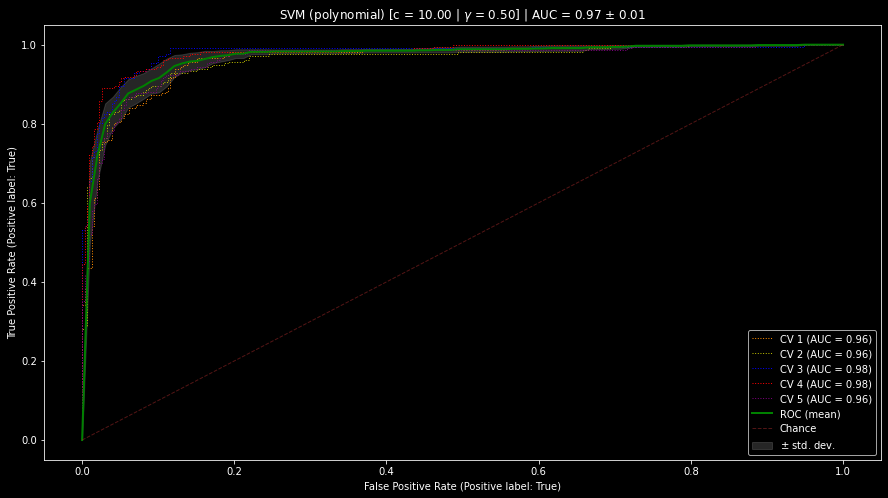

SVM (polynomial) [c = 10.00 | $\gamma$ = 0.50]: avg accuracy: 0.91, avg precision: 0.93, avg recall: 0.82


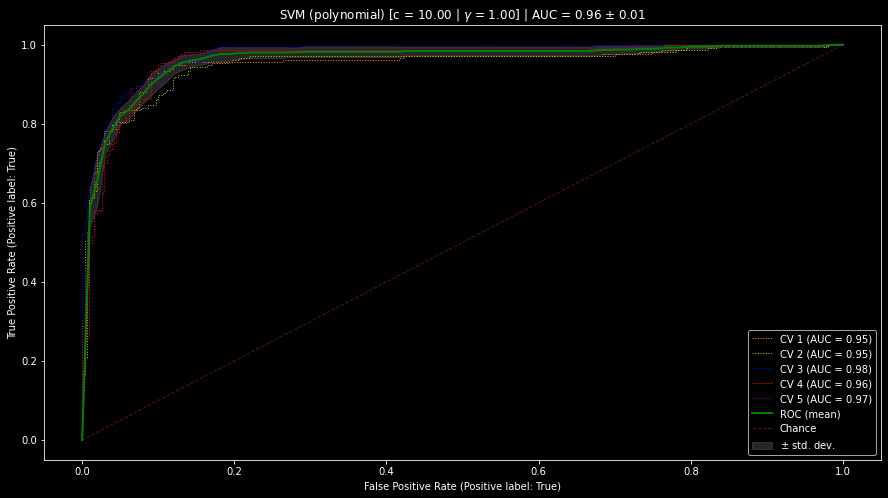

SVM (polynomial) [c = 10.00 | $\gamma$ = 1.00]: avg accuracy: 0.87, avg precision: 0.95, avg recall: 0.80


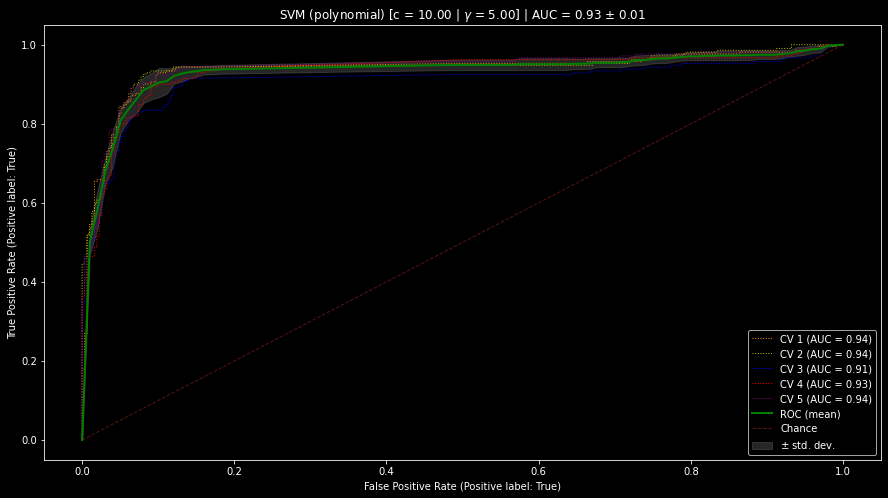

SVM (polynomial) [c = 10.00 | $\gamma$ = 5.00]: avg accuracy: 0.63, avg precision: 1.00, avg recall: 0.79


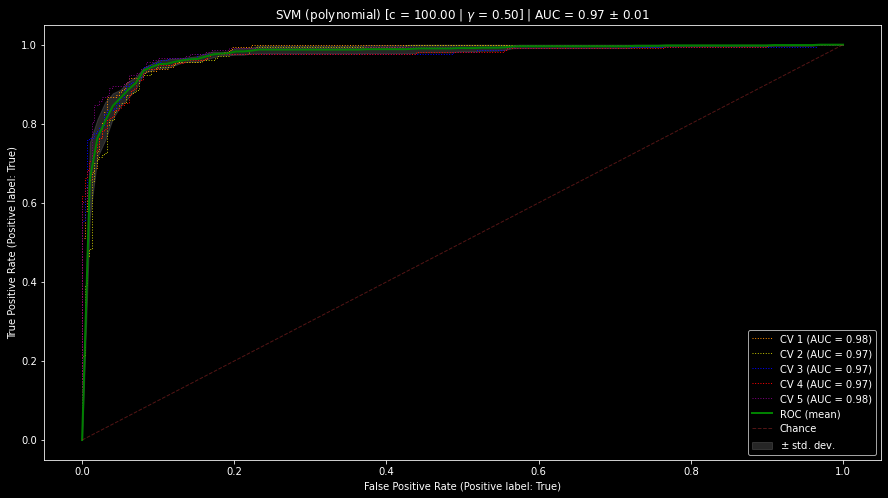

SVM (polynomial) [c = 100.00 | $\gamma$ = 0.50]: avg accuracy: 0.92, avg precision: 0.92, avg recall: 0.84


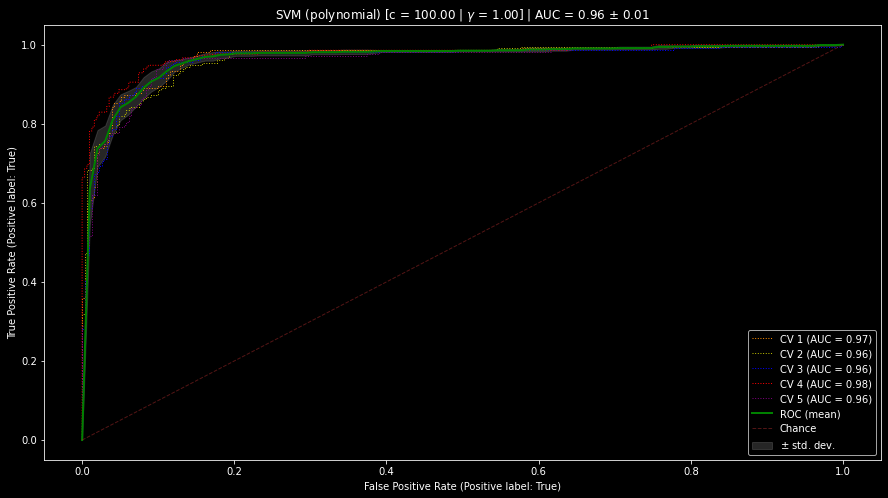

SVM (polynomial) [c = 100.00 | $\gamma$ = 1.00]: avg accuracy: 0.87, avg precision: 0.96, avg recall: 0.82


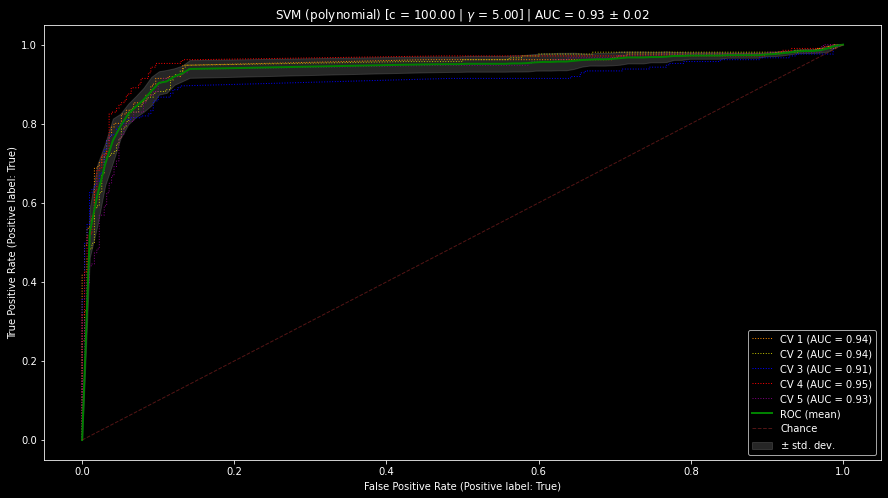

SVM (polynomial) [c = 100.00 | $\gamma$ = 5.00]: avg accuracy: 0.63, avg precision: 1.00, avg recall: 0.79


In [9]:
for c in cValues:
    for gamma in gammaValues:
        title = r"SVM (RBF) [c = %.2f | $\gamma$ = %.2f]" % (c, gamma)
        classifier = svm.SVC(C=c, kernel='rbf', gamma=gamma)
        cv_and_roc(classifier=classifier, title=title, X=X, y=y, k=k, colors=colors)

### KNN

O KNN ('K' vizinhos mais próximos) avalia, para cada amostra a ser classificada, qual classe ocorre com maior frequência entre os elementos conhecidos ao seu redor. Os elementos conhecidos são as amostras de treinamento.


O procedimento é muito intuitivo e a seleção do melhor modelo consiste em buscar determinar o valor mais adequado para o hiper parâmetro K (valor que determina quantos 'vizinhos' devem ser considerados na comparação).

Para valores de k menores, o modelo tende a ser menos específico. Para valores maiores, mais específico. O que funciona melhor é particular de cada caso.

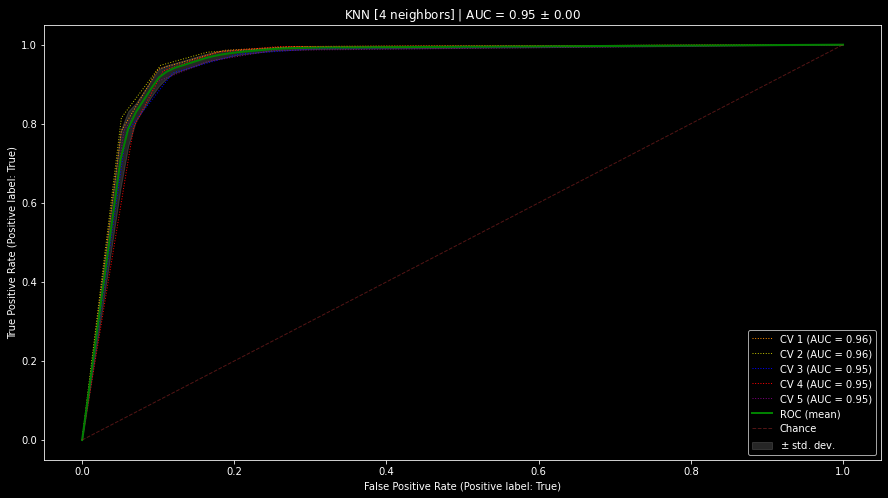

KNN [4 neighbors]: avg accuracy: 0.91, avg precision: 0.86, avg recall: 0.78


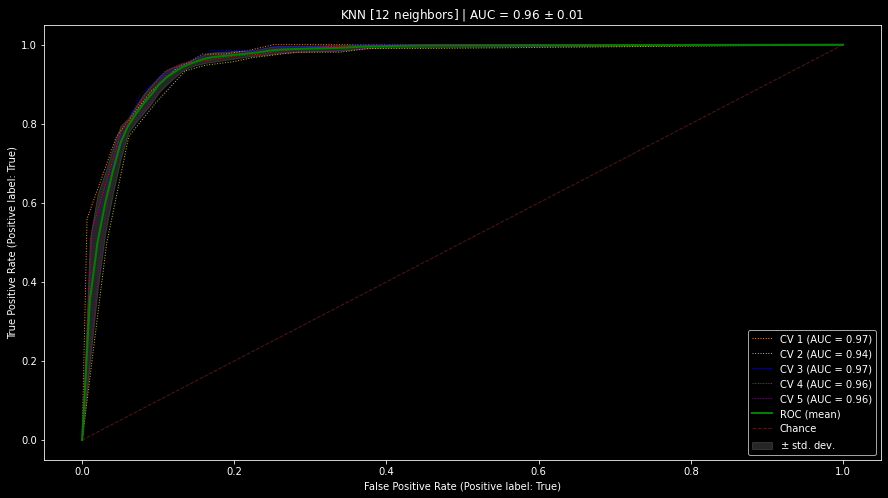

KNN [12 neighbors]: avg accuracy: 0.88, avg precision: 0.79, avg recall: 0.85


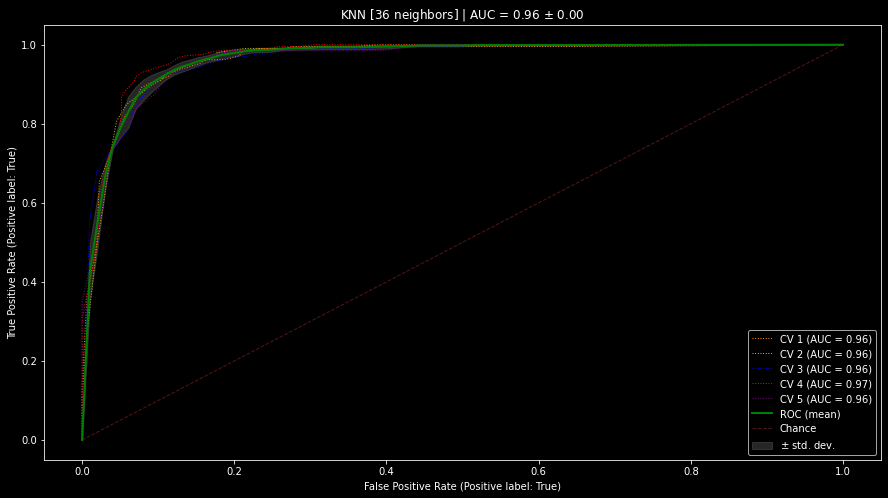

KNN [36 neighbors]: avg accuracy: 0.87, avg precision: 0.77, avg recall: 0.87


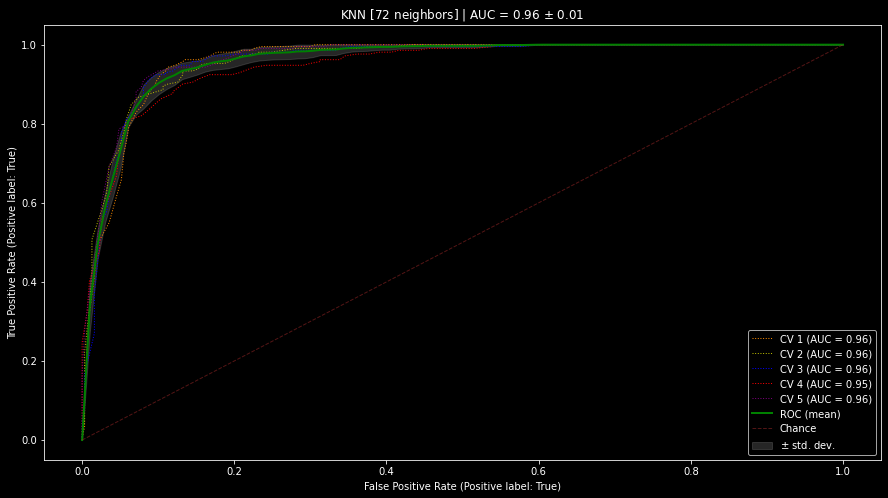

KNN [72 neighbors]: avg accuracy: 0.84, avg precision: 0.73, avg recall: 0.85


In [13]:

for n in [4, 12, 36, 72]:
    title = r"KNN [%d neighbors]" % (n)
    classifier = neighbors.KNeighborsClassifier(n_neighbors=n)
    cv_and_roc(classifier=classifier, title=title, X=X, y=y, k=k, colors=colors)

### Random Forest

Algoritmos 'floresta' utilizam a combinação de diversas árvores de decisão para determinar uma única classificação. O random Forest (floresta aleatória) inclui ao processo de construção tradicional de árvores de decisão um elemento de aleatoriedade. O objetivo é reduzir a propensão a overfitting tradicional desse tipo de abordagem.

Em cada nó, a construção da árvore leva em conta somente um subconjunto de amostras e um subconjunto de características. Esses subconjuntos são destacados aleatoriamente dos dados dispobíveis.

No momento da classificação, os dados são apreciados pela avaliação de cada árvore individualmente e, o veredito é dado pela média dos resultados de todas elas.

Para seleção da melhor floresta, avaliamos diversos números de árvores.

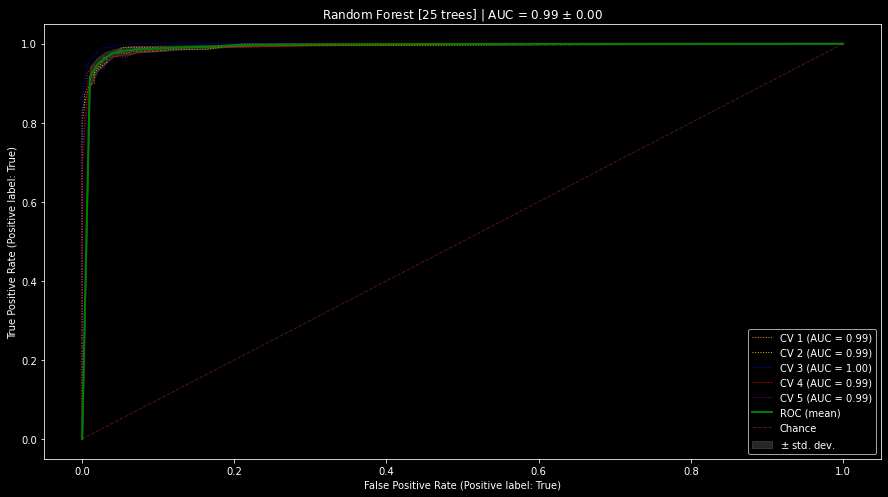

Random Forest [25 trees]: avg accuracy: 0.97, avg precision: 0.96, avg recall: 0.88


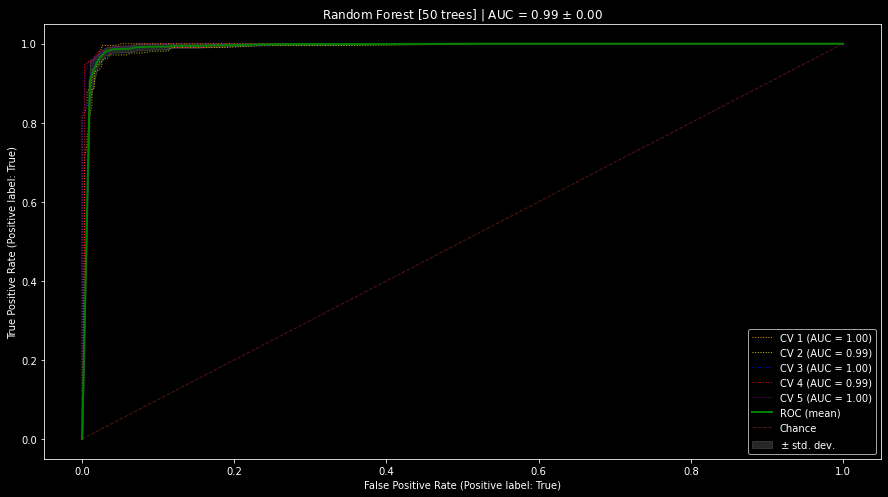

Random Forest [50 trees]: avg accuracy: 0.98, avg precision: 0.97, avg recall: 0.88


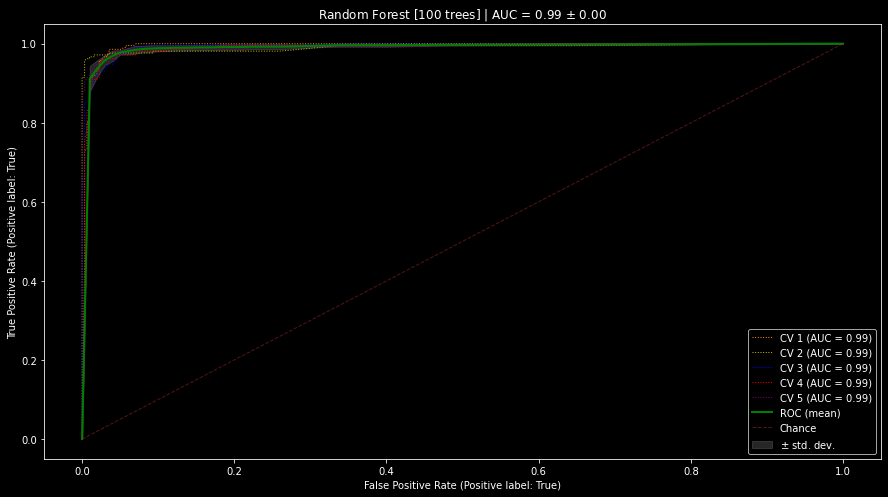

Random Forest [100 trees]: avg accuracy: 0.97, avg precision: 0.96, avg recall: 0.88


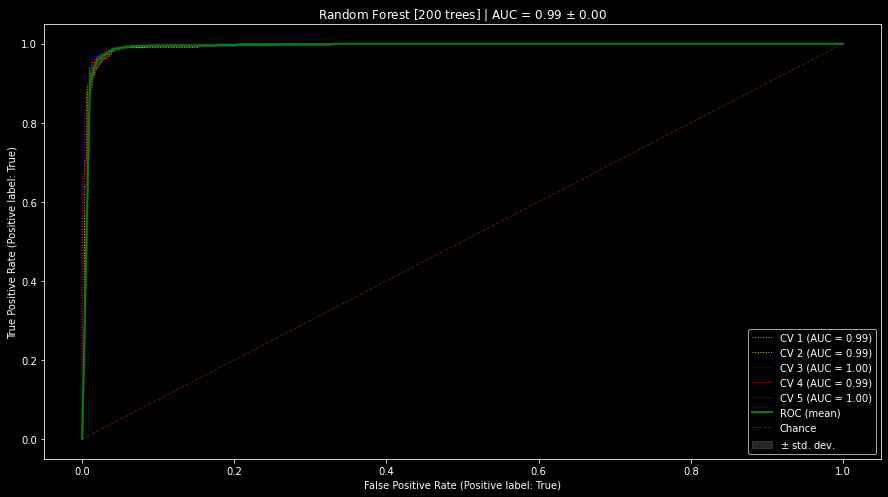

Random Forest [200 trees]: avg accuracy: 0.97, avg precision: 0.96, avg recall: 0.87


In [6]:
for n_trees in [25, 50, 100, 200]:
    title = r"Random Forest [%d trees]" % (n_trees)
    classifier = ensemble.RandomForestClassifier(n_estimators=n_trees)
    cv_and_roc(classifier=classifier, title=title, X=X, y=y, k=k, colors=colors)

### Gradient Tree Boosting

O algoritmo Gradient Tree Boosting, assim como o Random Forest, explora a ideia de combinar o resultado da classificação de diversos sub classificadores para reduzir o overfitting e melhorar o desempenho do classificador. Diferentemente do método anterior o GTB não utiliza árvores de decisão mas sim outro tipo de estrutura de árvore: Os 'weak learners' (aprendizes fracos) ou _stumps_. Cada aprendiz fraco é como uma pequena árvore de decisão que possui somente um nó e duas folhas.

Naturalmente a capacidade de classificação de um stump é muito pequena. A estratégia do classificador gradient boost é combinar vários stumps poderando a influência de cada um deles por pesos que são ajustados via otimização por descida de gradiente.

O principal hiper parâmetro que avaliamos nos experimentos a seguir é a quantidade de stumps usados.

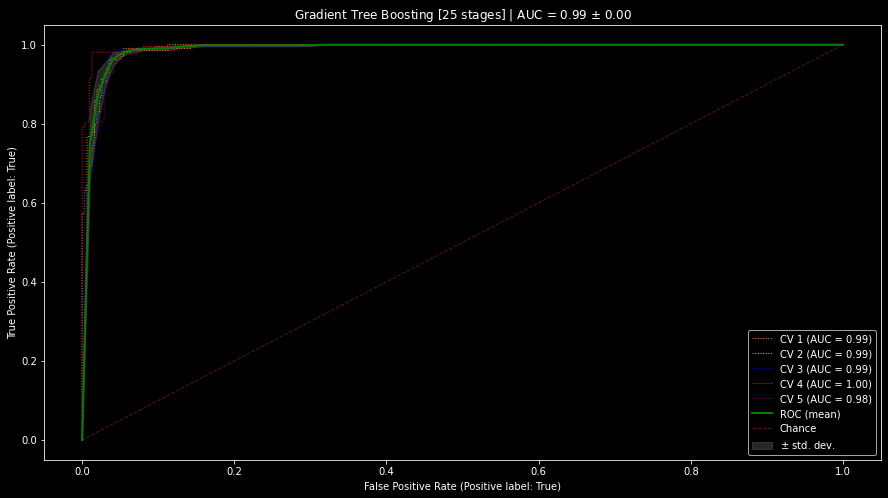

Gradient Tree Boosting [25 stages]: avg accuracy: 0.96, avg precision: 0.95, avg recall: 0.91


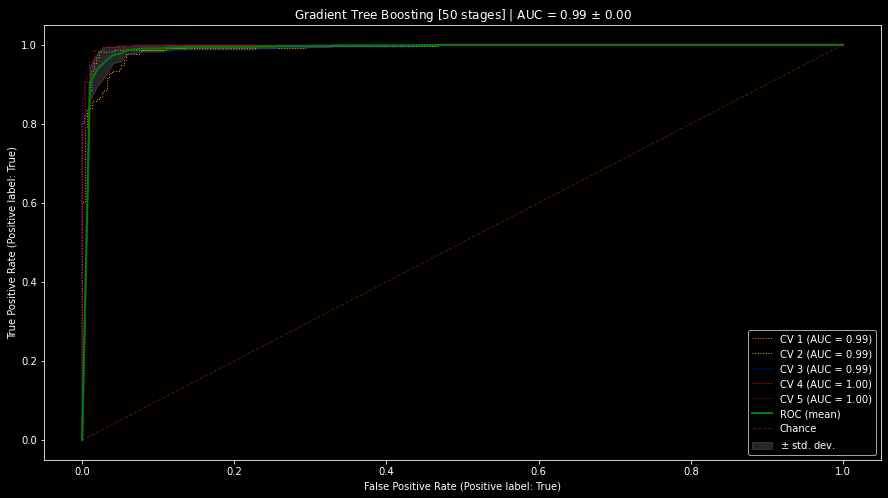

Gradient Tree Boosting [50 stages]: avg accuracy: 0.97, avg precision: 0.96, avg recall: 0.73


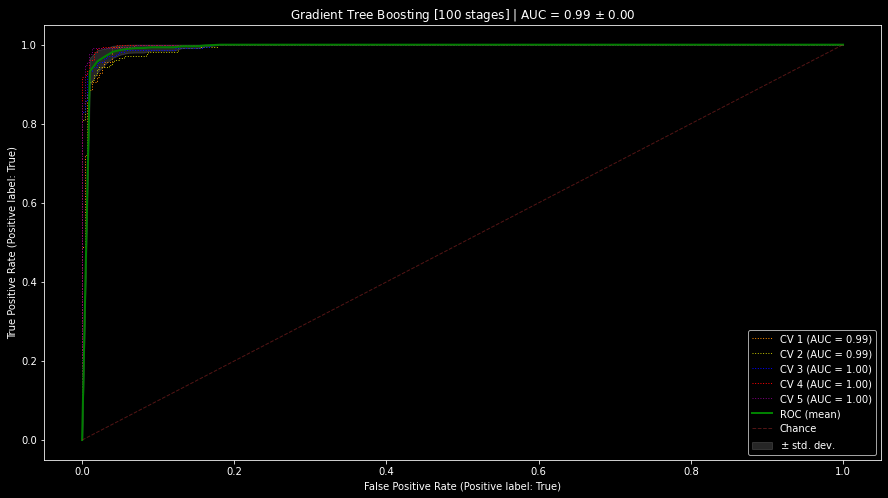

Gradient Tree Boosting [100 stages]: avg accuracy: 0.97, avg precision: 0.96, avg recall: 0.70


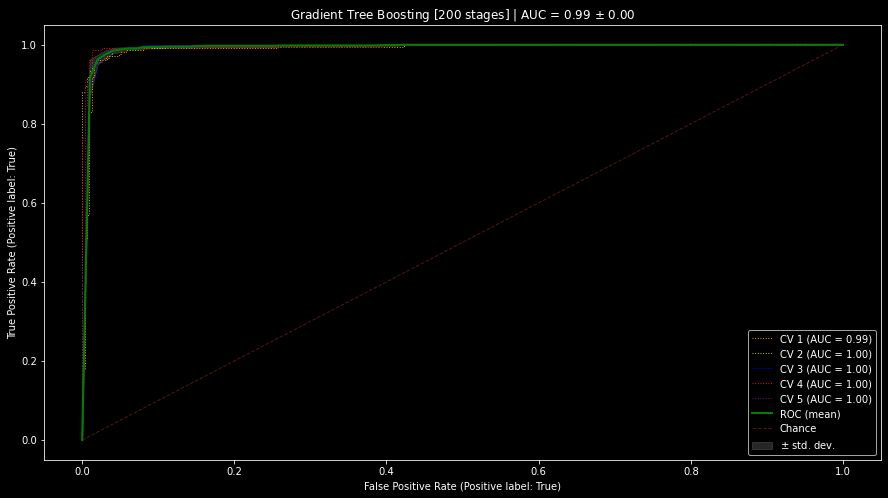

Gradient Tree Boosting [200 stages]: avg accuracy: 0.97, avg precision: 0.96, avg recall: 0.84


In [18]:
for n_stages in [25, 50, 100, 200]:
    title = r"Gradient Tree Boosting [%d stages]" % (n_stages)
    classifier = ensemble.GradientBoostingClassifier(n_estimators=n_stages)
    cv_and_roc(classifier=classifier, title=title, X=X, y=y, k=k, colors=colors)

## Conclusions

Naive Bayes

Primeiramente observamos um desempenho expressivo no classificador Naive Bayes, indício que aponta que o problema analisado pode ser de fácil separação.

Decision Tree

Vemos que o melhor desempenho para árvores de decisão ocorre com um limite de comprimento baixo de apenas 5. Isso reforça a percepção de que os dados são fáceis de separar e é uma constatação boa do ponto de vista de custo computacional. Apenas 5 níveis são suficientes logo não há necessidade de usar um modelo de árvore maior.

SVM

Á métrica utilizada indica um bom desempenho do classificador com kernel linear. Entretanto não se deve confiar nesse valor uma vez que o sabemos que para esse modelo a otimização não convergiu. Logo nossos dados não devem ser linearmente separáveis e o classificador linear não serve para os nossos propósitos.

O kernel sigmoidal se mostrou de baixo desempenho em relação aos demais em todos os 12 testes realizados.

O treinamento para kernel polinomial foi o mais custoso computacionalmente. Entretanto os resultados são muito bons para polinômio de grau 2 mas não tanto para grau 3, com o qual os resultados foram semelhantes aos de outros kernels cujo o treinamento foi menos demorado.

Obtemos bons resultados com kernel radial.

KNN

Todos os modelos tiveram bom desempenho. O modelo mais abrangente (k = 72) foi ligeiramente inferior aos demais. Dentre eles, a escolha do melhor poderia envolver mais testes (e.g.: tempo médio gasto para classificação) 

Random Forest $+$ Gradient Tree Booting

Ambos os algoritmos do tipo 'ensemble' obtiveram desempenho excepcional na classificação. Tal como o esperado, esses algoritmos atingiram os maiores níveis na classificação devido a estratégia de combinar resultados de múltiplos classificadores.